## Download packages

In [1]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import ExtraTreesClassifier
from k_means_constrained import KMeansConstrained
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph 
from scipy.sparse.linalg import expm
import scipy
from skfeature.utility import construct_W
from skfeature.function.similarity_based import lap_score
from tqdm.notebook import tqdm
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer, InterclusterDistance
import math
import time
import openpyxl

# Display settings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Load modeling data

In [2]:
# read in modeling data (output from Data Pipeline) -- make sure path is set up for your local computer
model_data = pd.read_csv('modeling_data_afterKNN.csv', dtype={'siteiid': str,
                                                              'mlra_id': str}) #, nrows = 1000) #read only 1000 rows for test run
# check dimensions of modeling dataset
model_data.shape

(547038, 478)

In [3]:
model_data.head()

,siteiid,slope,aspect,benchmarks,commphasei,soilreplic,pmorder,psctopdepth,noncarbclaywtavg,claytotwtavg,cec7clayratiowtavg,hillslopep_Backslope,hillslopep_Footslope,hillslopep_Shoulder,hillslopep_Summit,hillslopep_Toeslope,shapeacros_Concave,shapeacros_Convex,shapeacros_Linear,shapedown_Concave,shapedown_Convex,shapedown_Linear,drainagecl_Excessively drained,drainagecl_Moderately well drained,drainagecl_Poorly drained,drainagecl_Somewhat excessively drained,drainagecl_Somewhat poorly drained,drainagecl_Very poorly drained,drainagecl_Well drained,pmgroupnam_OTHER,pmgroupnam_alluvium,pmgroupnam_loess,flodfreqcl_Frequent,flodfreqcl_None,flodfreqcl_Occasional,flodfreqcl_Rare,taxonname_OTHER,taxonname_SND,taxclname_Mesic,taxclname_OTHER,taxonkind_Family,taxonkind_Series,taxonkind_Taxadjunct,taxonkind_Taxon above family,earthcovki_Crop cover,earthcovki_Grass/herbaceous cover,earthcovki_Shrub cover,earthcovki_Tree cover,earthcov_1_Close-grown crop,earthcov_1_Conifers,earthcov_1_Grassland rangeland,earthcov_1_Hardwoods,earthcov_1_Hayland,earthcov_1_Intermixed conifers and hardwoods,earthcov_1_Native shrubs,earthcov_1_Other grass/herbaceous cover,earthcov_1_Row crop,earthcov_1_Shrubby rangeland,earthcov_1_Tame pastureland,pedonhydri_YES,pmkind_OTHER,pmorigin_OTHER,layertype_0cm_9cm_Horizon,layertype_0cm_9cm_Reporting layer,layertype_100cm_109cm_Horizon,layertype_100cm_109cm_Reporting layer,layertype_10cm_19cm_Horizon,layertype_10cm_19cm_Reporting layer,layertype_110cm_119cm_Horizon,layertype_110cm_119cm_Reporting layer,layertype_120+cm_Horizon,layertype_120+cm_Reporting layer,layertype_20cm_29cm_Horizon,layertype_20cm_29cm_Reporting layer,layertype_30cm_39cm_Horizon,layertype_30cm_39cm_Reporting layer,layertype_40cm_49cm_Horizon,layertype_40cm_49cm_Reporting layer,layertype_50cm_59cm_Horizon,layertype_50cm_59cm_Reporting layer,layertype_60cm_69cm_Horizon,layertype_60cm_69cm_Reporting layer,layertype_70cm_79cm_Horizon,layertype_70cm_79cm_Reporting layer,layertype_80cm_89cm_Horizon,layertype_80cm_89cm_Reporting layer,layertype_90cm_99cm_Horizon,layertype_90cm_99cm_Reporting layer,moistprepstate_0cm_9cm_Air-dry,moistprepstate_100cm_109cm_Air-dry,moistprepstate_10cm_19cm_Air-dry,moistprepstate_110cm_119cm_Air-dry,moistprepstate_120+cm_Air-dry,moistprepstate_20cm_29cm_Air-dry,moistprepstate_30cm_39cm_Air-dry,moistprepstate_40cm_49cm_Air-dry,moistprepstate_50cm_59cm_Air-dry,moistprepstate_60cm_69cm_Air-dry,moistprepstate_70cm_79cm_Air-dry,moistprepstate_80cm_89cm_Air-dry,moistprepstate_90cm_99cm_Air-dry,Feature_Type_Landform,Feature_Type_Landscape,Feature_alluvial fan,Feature_coastal plain,Feature_drainageway,Feature_flood plain,Feature_foothills,Feature_ground moraine,Feature_hill,Feature_hills,Feature_hillslope,Feature_interfluve,Feature_intermontane basin,Feature_lake plain,Feature_mountain,Feature_mountain slope,Feature_mountains,Feature_other,Feature_outwash plain,Feature_piedmont,Feature_plain,Feature_plains,Feature_plateau,Feature_ridge,Feature_river valley,Feature_stream terrace,Feature_terrace,Feature_till plain,Feature_upland,Feature_valley,pptannual,tdmeanannual,tmaxannual,tmeanannual,tminannual,vpdmaxannual,vpdminannual,NDVI_5Pct,NDVI_IQR90,NDVI_95Pct,SATVI_5Pct,SATVI_IQR90,SATVI_95Pct,obsmethod_10_Push Tube,obsmethod_40_Small Pit,obsmethod_100_Bucket Auger,obsmethod_20_Bucket Auger,obsmethod_70_Bucket Auger,obsmethod_90_Bucket Auger,obsmethod_60_Bucket Auger,obsmethod_90_Small Pit,obsmethod_80_Small Pit,obsmethod_80_Bucket Auger,obsmethod_110_Bucket Auger,obsmethod_60_Push Tube,obsmethod_70_Push Tube,obsmethod_70_Small Pit,obsmethod_10_Small Pit,obsmethod_30_Push Tube,obsmethod_30_Small Pit,obsmethod_0_Small Pit,obsmethod_20_Small Pit,obsmethod_80_Push Tube,obsmethod_0_Push Tube,obsmethod_110_Push Tube,obsmethod_120_Bucket Auger,obsmethod_120_Small Pit,obsmethod_50_Bucket Auger,obsmethod_90_Push Tube,obsmethod_20_Push Tube,obsmethod_100_Push Tube,obsmethod_40_Push Tube,obsmethod_40_Bucket Auger,obsmethod_60_Small Pit,obsmethod_

## Feature selection and clustering function

In [4]:
class mlra_groups():
    def __init__(self,model_data,groupName):
        # put climate variables in a list (recall we will only use top ranked climate variable within each climate family of variables)      
        SATVI_features = model_data.columns[model_data.columns.str.startswith('SATVI')]
        NDVI_features = model_data.columns[model_data.columns.str.startswith('NDVI')]

        ppt_feature = model_data.columns[model_data.columns.str.lower().str.contains('|'.join(['ppt','precipitation']))]

        vpdmax_feature = model_data.columns[model_data.columns.str.lower().str.contains('vpdmax')]
        vpdmin_feature = model_data.columns[model_data.columns.str.lower().str.contains('vpdmin')]

        tdm_feature = model_data.columns[model_data.columns.str.lower().str.contains('|'.join(['tdm','dewpoint']))]
        tmean_features = model_data.columns[model_data.columns.str.lower().str.contains('|'.join(['tmean','tempmean']))]
        tmin_features = model_data.columns[model_data.columns.str.lower().str.contains('|'.join(['tmin','tempmin']))]
        tmax_features = model_data.columns[model_data.columns.str.lower().str.contains('|'.join(['tmax','tempmax']))]
        # feat_list contains all climate variables in a list
        self.feat_list = [SATVI_features, NDVI_features, ppt_feature, vpdmax_feature, vpdmin_feature,
                     tdm_feature, tmean_features, tmin_features, tmax_features]

        # put mlra variables in a list (i.e. mlra_id, lrr_id, etc)
        target_var_list = model_data.columns[model_data.dtypes=='object'].tolist() + ['mlra_id']
        # put plant variables in a list
        plant_features = model_data.columns[model_data.columns.str.startswith('PlantName_')]
        # put geographic location variables in a list
        geographic_loc_info = ['latstddeci','longstddec','elev']
        # put "OTHER" variables in a list
        other_type_var = other_type_var = [x for x in list(model_data) if 'other' in x.lower()] + ['HorizonMasterOth0to10Index',
                            'HorizonMasterOth10to30Index','HorizonMasterOth40to70Index','HorizonMasterOth80to100Index',
                            'HorizonNameOth_30to120Index','HorizonTextureOTH_0to60Index','HorizonTextureOTH_60to120Index']
        # make layer and obsmethof variables lowercase
        layer_type_var = [x for x in list(model_data) if 'layertype' in x.lower()]
        obsmethod_var = [x for x in list(model_data) if 'obsmethod' in x.lower()]
        # set input features (excludes certain variables not part of clustering)
        self.input_features=list(set(model_data)-
                            {'siteiid'}-
                            set(target_var_list)- # mostly mlra/lrr ids, not needed for clustering
                            set(plant_features)- # not enough coverage across sites
                            set(geographic_loc_info)- # not needed for clustering
                            set(layer_type_var)- # not needed for clustering
                            set(obsmethod_var)- # not needed for clustering
                            set(other_type_var) # no need for "OTHER" variables, hard to interpret
                           )
        self.groupName = groupName
        self.model_data = model_data
    # function that chooses top climate variables to include within each climate family after feat selection   
    def choose_top_of_category(self,feature_set,org_feat_df):
        org_feat_df.loc[org_feat_df[org_feat_df.features.isin(feature_set)].index[1:],'feature_ranks']=0
        return org_feat_df

    # function that groups features into "x" and the target ecoclassname into "y" then implements
    # tree classifier to perform feature selection, generating a dataframe that shows scores
    def feature_select_func(self,mlra_specific_data_known_eco):
        x = mlra_specific_data_known_eco[self.input_features]
        y = mlra_specific_data_known_eco['ecoclassname']
        # define the Tree Classifier model
        model = ExtraTreesClassifier(n_estimators=1000,random_state=42)
        model.fit(x, y)
        # create dataframe of features and its associated scores sorted by descending order
        feat_df = pd.DataFrame()
        feat_df ['feature_ranks'] = model.feature_importances_
        feat_df ['features'] = pd.Series(self.input_features).reset_index(drop=True)
        feat_df.sort_values(by='feature_ranks',inplace=True,ascending=False,ignore_index=True)
        return(feat_df)
    
    # Certain MLRA groups don't have enough ecoclassname targets to perform tree based classification
    # in these cases, the LaPlacian method is used for feature selection
    def group_specific_feature_select_func(self):

        group_specific_data = self.model_data.loc[self.model_data.ClusterGroup == self.groupName].copy().reset_index()
        print('subseting for {}, the shape is : '.format(self.groupName),group_specific_data.shape)
        # the MLRA groups that use Laplacian Score for their feature selection        
        if self.groupName in ['Q1','Z1','S2','N7','C4','W2','S1']:
            # to numpy(2D array)
            # all should be numbers
            self.optimal_number_features = 20
            group_specific_data_arr = group_specific_data[self.input_features].to_numpy()
            # set up parameters for constructing the affinity matrix W
            kwargs_W = {"metric":"euclidean","neighbor_mode":"knn","weight_mode":"heat_kernel","k":5,'t':1}
            # construct the affinity matrix W 
            W = construct_W.construct_W(group_specific_data[self.input_features], **kwargs_W)
            # generating ls score
            score =lap_score.lap_score(group_specific_data_arr,mode='rank', W=W)
            # generate dataframe with features ranked by ls score
            ls_df = pd.DataFrame(columns= ['features'])
            ls_df['features'] =pd.Series(self.input_features)
            feat_df = ls_df.iloc[score].reset_index(drop=True)         
        else:
            # find the sites where there exists an ecoclassname
            group_specific_data_known_eco=group_specific_data[group_specific_data['ecoclassname'].notna()]
            print('subseting for group = {} with known ecoclassname, the shape is : '.format(self.groupName),
                  group_specific_data_known_eco.shape)
            # count the number of ecosites
            valueCounts =group_specific_data_known_eco['ecoclassname'].value_counts('normalize').reset_index().rename(columns=
                           {'ecoclassname':'ecocount'})
            # determine the ecoclassnames to keep and the ones to group using the 99% rule (group ecoclassnames that make up >1% of the data into 'OTHER')
            valuesToKeep = valueCounts[valueCounts['ecocount'] >= 0.01]
            valuesToGroup = valueCounts[valueCounts['ecocount'] < 0.01]

            # reset the values to group to 'OTHER'
            group_specific_data_known_eco.loc[group_specific_data_known_eco['ecoclassname'].isin(
                        valuesToGroup['index']), 'ecoclassname'] = 'OTHER'

            original_feat_df = self.feature_select_func(group_specific_data_known_eco)

            for feat_set in self.feat_list:
                feat_df = self.choose_top_of_category(feat_set,original_feat_df)
            # rank features in descending order by score for output file
            feat_df.sort_values(by='feature_ranks',inplace=True,ascending=False,ignore_index=True)
            # features that meet the >0.005 tree classifier score threshold
            self.optimal_number_features = feat_df.loc[feat_df['feature_ranks']>=0.005].shape[0]
        self.group_feat_df = feat_df
        self.group_data = group_specific_data

    # function to find k, the optimal cluster size
    def find_optimum_k(self):
        # list of features that meet the >0.005 tree classification score threshold
        self.feat_set = self.group_feat_df.loc[0:self.optimal_number_features-1,'features'].tolist()
        scaler = StandardScaler(with_mean=True, with_std=True)
        # scale the data before input into KMeans clustering
        standardScale_data = scaler.fit_transform(self.group_data[self.feat_set])
        # define KMeans model
        model = KMeans(random_state=42)
        # set parameters, k in this instance is the range of number of clusters
        visualizer = KElbowVisualizer(model, k=(10,50), timings=False, metric = 'distortion',random_state=42)
        visualizer.fit(standardScale_data)            # fit the data to the visualizer
        visualizer.show(outpath="kelbow_kmeans.png")  # generate a picture of the elbow graph
        visualizer.poof() # clear "cache" for next loop
        plt.gcf().clear() 
        self.optimal_number_clusters = visualizer.elbow_value_
        
        print('optimal number of k = {}, number_features = {}'.format(self.optimal_number_clusters,
                                                                      self.optimal_number_features))
    def best_model_kmeans(self):
        site_count = self.group_data.shape[0] # number of sites in this cluster group
        number_clusters = self.optimal_number_clusters # number of clusters k
        min_possible =  min(math.floor(site_count/number_clusters), 30) # set threshold for min cluster size
        # set up constrained KMeans model with parameters that can be tuned
        model = KMeansConstrained(size_min = max(min_possible, round(site_count*0.01)),
                                  size_max = site_count*0.2,
                                  n_clusters= self.optimal_number_clusters,
                                  random_state=42,tol=0.001)
        scaler = StandardScaler() # define standard scaler
        standardScale_data = scaler.fit_transform(self.group_data[self.feat_set]) # standardize the data prior to insertion into model
        res = model.fit(standardScale_data) # fit the model
        
        pred = res.labels_ # generate cluster labels
        self.group_data['Cluster'] = pd.Series(pred)
        self.group_data['Cluster'] = self.group_data['Cluster'].apply(lambda x:'cluster ' + str(x))
    
    # function that generates the n largest elements of an input dataframe dist_row in a list
    def nlargest_func(self,dist_row):
        n=int(dist_row['nlargest'])
        dist_row['nlargest'] = 0
        return(dist_row.nlargest(n).index.tolist())
    
    # function that generates the output files per cluster group. total of 99 cluster output files
    def write_to_excel(self):
        sorted_largest_cluster = self.group_data['Cluster'].value_counts().index.tolist()
        
        # generate cluster size chart
        self.cluster_site_df = self.group_data['Cluster'].value_counts().reset_index().rename(
        columns={'index':'Cluster','Cluster':'Number of Sites'})
               
        # generate features distribution matrix
        feat_dist_unsorted_df = self.group_data[['Cluster'] + self.feat_set].groupby('Cluster').mean()
        feat_dist_unsorted_df.index.name = ''
        self.feat_dist_df = feat_dist_unsorted_df.loc[sorted_largest_cluster]
        
        # generate top features and attach to features matrix
        scaler = StandardScaler(with_mean=True, with_std=True)
        feat_dist_df_scaled = scaler.fit_transform(self.feat_dist_df)
        feat_dist_df_scaled = pd.DataFrame(feat_dist_df_scaled, columns = self.feat_dist_df.columns)
        feat_dist_df_scaled['Cluster'] = self.cluster_site_df['Cluster']
        list_of_inputs = self.feat_dist_df.columns.to_list()

        features_scaled_melt = pd.melt(feat_dist_df_scaled, id_vars=['Cluster'], value_vars=list_of_inputs)
        features_scaled_melt = features_scaled_melt.rename(columns = {'value': 'raw_scaled_value'})
        features_scaled_melt['abs_scaled_value'] = abs(features_scaled_melt['raw_scaled_value'])
        features_scaled_melt = features_scaled_melt.sort_values(by=['Cluster', 'abs_scaled_value'], ascending=False)
        # rank features by their standardized values for each cluster
        features_scaled_melt["rank"] = features_scaled_melt.groupby("Cluster")["abs_scaled_value"].rank("first", ascending=False)
        # designating whether a feature is above or below average based on its sign
        features_scaled_melt['avg_sign'] = np.sign(features_scaled_melt['raw_scaled_value']).replace(1, "ABOVE_AVG").replace(-1,"BELOW_AVG")
        features_scaled_melt['ranked_feature'] = features_scaled_melt[['variable', 'avg_sign']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
        # remove rows that are less than 1 in absolute scale (only values >=1 are included as a top feature)
        features_scaled_melt = features_scaled_melt[features_scaled_melt['abs_scaled_value'] >= 1.0] 
        features_scaled_melt_pivot = features_scaled_melt.pivot(index='Cluster', columns='rank', values='ranked_feature')
        # reindex by the largest cluster order via index_order
        features_scaled_melt_pivot = features_scaled_melt_pivot.reindex(sorted_largest_cluster)
        try:
            features_scaled_melt_pivot = features_scaled_melt_pivot.iloc[:, : 5] # keep only top 5 features, can adjust if want to show more features
            features_scaled_melt_pivot = features_scaled_melt_pivot.rename(columns = {1: '1st', 2: '2nd', 3: '3rd', 4: '4th', 5: '5th'})   
        except:
            pass
        # pivot back to original matrix format
        self.feat_dist_df_final = features_scaled_melt_pivot.join(self.feat_dist_df)     
        full_column_list = {'5th','4th','3rd','2nd','1st'}
        # make sure that clusters without all 1-5 features still have a placeholder (this avoids mismatched dataframe sizes)
        intersect_cols = full_column_list.intersection(set(self.feat_dist_df_final))
        if len(intersect_cols)==0:
            self.feat_dist_df_final.insert(0, '5th', np.nan)
            self.feat_dist_df_final.insert(0, '4th', np.nan)
            self.feat_dist_df_final.insert(0, '3rd', np.nan)
            self.feat_dist_df_final.insert(0, '2nd', np.nan)
            self.feat_dist_df_final.insert(0, '1st', np.nan)
        if len(intersect_cols)==1:
            self.feat_dist_df_final.insert(1, '5th', np.nan)
            self.feat_dist_df_final.insert(1, '4th', np.nan)
            self.feat_dist_df_final.insert(1, '3rd', np.nan)
            self.feat_dist_df_final.insert(1, '2nd', np.nan)
        if len(intersect_cols)==2:
            self.feat_dist_df_final.insert(2, '5th', np.nan)
            self.feat_dist_df_final.insert(2, '4th', np.nan)
            self.feat_dist_df_final.insert(2, '3rd', np.nan)
        if len(intersect_cols)==3:
            self.feat_dist_df_final.insert(3, '5th', np.nan)
            self.feat_dist_df_final.insert(3, '4th', np.nan)
        if len(intersect_cols)==4:
            self.feat_dist_df_final.insert(4, '5th', np.nan)  
        
        # generating ecoclassnames distribution
        self.group_data['group_ecoclassname'] = self.group_data['ecoclassname'].copy()
        valueCounts = self.group_data['group_ecoclassname'].value_counts(normalize=True).reset_index()
        # figure out the categories to keep and the ones to group using the 99% rule
        try:
            valuesToKeep = valueCounts[0:self.optimal_number_clusters]
            valuesToGroup = valueCounts[self.optimal_number_clusters:]
        except:
            valuesToKeep = valueCounts[valueCounts['group_ecoclassname'] >= 0.01]
            valuesToGroup = valueCounts[valueCounts['group_ecoclassname'] < 0.01]
        
        # reset the values to group to 'OTHER'
        self.group_data.loc[self.group_data['group_ecoclassname'].isin(valuesToGroup['index']), 'group_ecoclassname'] = 'OTHER'
        self.group_data.loc[self.group_data['group_ecoclassname'].isna(),'group_ecoclassname'] = 'NAN'
        
        unsorted_ecoclass_df = pd.crosstab(self.group_data['Cluster'],
                                           self.group_data['group_ecoclassname'],
                                           normalize='index') 
        unsorted_ecoclass_df.index.name = ''
        unsorted_ecoclass_df.columns.name = ''
        
        # ecoclass count
        unsorted_ecoclass_df_count = pd.crosstab(self.group_data['Cluster'],
                                           self.group_data['group_ecoclassname'])
        unsorted_ecoclass_df_count.index.name = ''
        unsorted_ecoclass_df_count.columns.name = ''
        self.ecoclass_dist_df_count = unsorted_ecoclass_df_count.loc[sorted_largest_cluster,
                                                list(set(unsorted_ecoclass_df_count) - {'NAN','OTHER'})]
               
        # remove NAN and OTHER before saving
        self.ecoclass_dist_df = unsorted_ecoclass_df.loc[sorted_largest_cluster,
                                                list(set(unsorted_ecoclass_df) - {'NAN','OTHER'})]
        
        non_zero_df = self.ecoclass_dist_df.mask(self.ecoclass_dist_df>0).fillna(1).sum(axis=1).apply(lambda x:
                                                    int(min(x,3))).to_frame().rename(columns={0:'nlargest'})
        self.ecoclass_dist_df = non_zero_df.join(self.ecoclass_dist_df)
        
        # generating top 3 ecoclassnames
        df_= self.ecoclass_dist_df.apply(lambda s: self.nlargest_func(s), axis=1)
        df_ = df_.to_frame()
        df = pd.DataFrame(df_[0].values.tolist(),index= df_.index)
        df.index.name='Cluster'
        df.rename(columns={0:'1st',1:'2nd',2:'3rd'},inplace=True)
        
        self.ecoclass_dist_df.drop(columns=['nlargest'],inplace=True)
        # make sure that clusters without all 1-3 ecoclassnames have a placeholder (this avoids mismatched dataframe sizes)
        if df.shape[1]==0:
            self.ecoclass_dist_df.insert(0, '3rd', np.nan)
            self.ecoclass_dist_df.insert(0, '2nd', np.nan)
            self.ecoclass_dist_df.insert(0, '1st', np.nan)
            
            self.ecoclass_dist_df_count.insert(0, '3rd', np.nan)
            self.ecoclass_dist_df_count.insert(0, '2nd', np.nan)
            self.ecoclass_dist_df_count.insert(0, '1st', np.nan)
        else:
            self.ecoclass_dist_df = df.join(self.ecoclass_dist_df)
            self.ecoclass_dist_df_count = df.join(self.ecoclass_dist_df_count)
            
        if df.shape[1]==1:
            self.ecoclass_dist_df.insert(1, '3rd', np.nan)
            self.ecoclass_dist_df.insert(1, '2nd', np.nan)
            
            self.ecoclass_dist_df_count.insert(1, '3rd', np.nan)
            self.ecoclass_dist_df_count.insert(1, '2nd', np.nan)
        if df.shape[1]==2:
            self.ecoclass_dist_df.insert(2, '3rd', np.nan)
            self.ecoclass_dist_df_count.insert(2, '3rd', np.nan)
            
        # generate location data for mapping
        self.df_location = self.group_data[['siteiid', 'latstddeci','longstddec','elev', 
                              'Cluster', 'ecoclassname']]        
        
        save_data = self.group_data.copy()
        save_data['group_cluster'] = self.groupName + '_' + save_data.Cluster
        
        eco_top = self.ecoclass_dist_df[['1st','2nd','3rd']].reset_index()
        eco_top.rename(columns={'1st':'1st_ecoclass','2nd':'2nd_ecoclass','3rd':'3rd_ecoclass'},
                       inplace=True)
        # rename column names to final header names
        feature_top = self.feat_dist_df_final[['1st','2nd','3rd','4th','5th']].reset_index()
        feature_top.rename(columns={'1st':'1st_feature','2nd':'2nd_feature',
                                    '3rd':'3rd_feature','4th':'4th_feature','5th':'5th_feature'},inplace=True)\
        
        save_data_topeco = save_data.merge(eco_top,on='Cluster',how='left')
        save_data_topeco_topfeature= save_data_topeco.merge(feature_top,on='Cluster',how='left')
        save_data_topeco_topfeature.drop(columns=['index','Cluster', 'group_ecoclassname'],inplace=True)
        
        # save cluster, top features, and top ecoclassnames into separate file for combining with modeling dataset
        save_data_topeco_topfeature.to_csv('Cluster_Group_Datasets/{}_model_data.csv'.format(self.groupName), index=False)
        
        with pd.ExcelWriter('Output Files/{}_output.xlsx'.format(self.groupName), engine='xlsxwriter') as writer:
            # generate the different output information for each output file tab                                     
            self.feat_dist_df_final.to_excel(writer, sheet_name='feature distribution')
            self.ecoclass_dist_df_count.to_excel(writer, sheet_name='ecoclass distribution')
            self.cluster_site_df.to_excel(writer, sheet_name='cluster sizes', index=False)
            self.group_feat_df.to_excel(writer, sheet_name = 'feature ranks', index=False)
            empty = pd.DataFrame()
            empty.to_excel(writer, sheet_name='elbow_graph')
            
            #img = openpyxl.drawing.image.Image('kelbow_kmeans.png')
            #img.anchor = 'B2'
            #worksheet = writer.sheets['elbow_graph'].add_image(img)
            
            worksheet = writer.sheets['elbow_graph'].insert_image('B2','kelbow_kmeans.png')
            self.df_location.to_excel(writer, sheet_name = 'Location data', index=False)

## List of cluster groups

In [5]:
#Groups = ['M3', 'E1']

In [6]:
# List of Cluster Groups
Groups = ['M3','E1','H3','D9','P1','N1','M2','D2','K4','E2','X2','E3',
           'H2','D7','W1','M7','T1','M1','R3','O1','I3','N6','D3','D4',
           'H4','X1','H1','M5','D6','H5','N5','K3','M10','G4','D1','N4',
           'S2','G1','P3','I1','L1','R2','R1','B2','M8','M4','K2','E4',
           'J1','H6','F3','M6','J3','K1','I2','T3','F1','T2','L2','A2',
           'S1','J4','A1','N3','J2','K5','P2','K6','G2','G5','F4','A3',
           'D8','C3','G6','N7','B3','G3','N2','C1','M9','B4','C2','B5',
           'W2','D5','A4','C4','B1','C5','U2','F2','E5','S3','U1','U3',
           'Q1','V1','Z1']         

## Loop to run through all cluster groups

subseting for M3, the shape is :  (33286, 479)
subseting for group = M3 with known ecoclassname, the shape is :  (11277, 479)


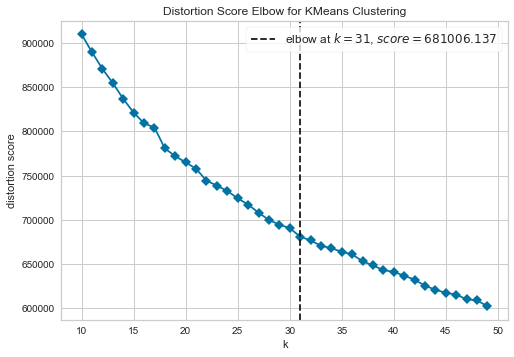

optimal number of k = 31, number_features = 47
--- run time : 11.649669043223064 min ---
subseting for E1, the shape is :  (32438, 479)
subseting for group = E1 with known ecoclassname, the shape is :  (4244, 479)


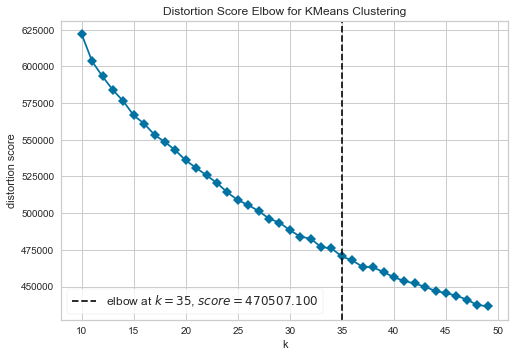

optimal number of k = 35, number_features = 33
--- run time : 14.946021238962809 min ---
subseting for H3, the shape is :  (21445, 479)
subseting for group = H3 with known ecoclassname, the shape is :  (10116, 479)


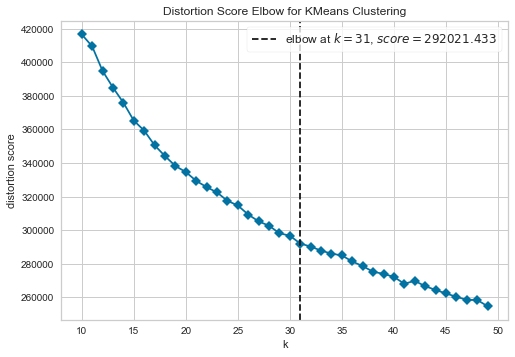

optimal number of k = 31, number_features = 35
--- run time : 6.357779276371002 min ---
subseting for D9, the shape is :  (20398, 479)
subseting for group = D9 with known ecoclassname, the shape is :  (4845, 479)


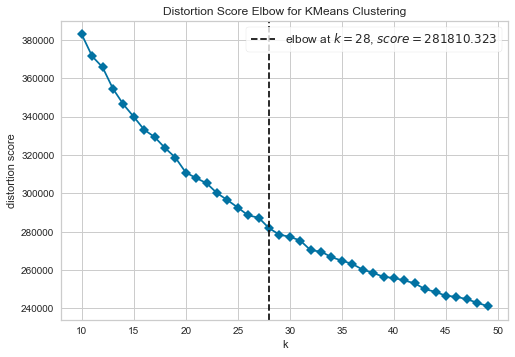

optimal number of k = 28, number_features = 33
--- run time : 6.041907298564911 min ---
subseting for P1, the shape is :  (15429, 479)
subseting for group = P1 with known ecoclassname, the shape is :  (4837, 479)


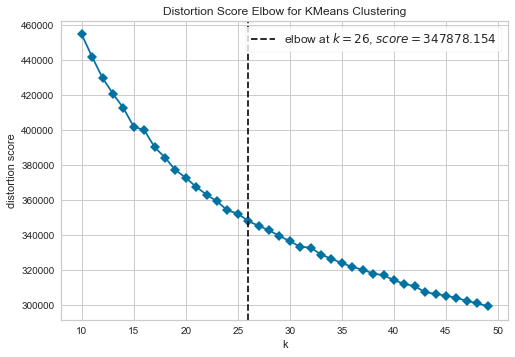

optimal number of k = 26, number_features = 45
--- run time : 3.987564440568288 min ---
subseting for N1, the shape is :  (15195, 479)
subseting for group = N1 with known ecoclassname, the shape is :  (5466, 479)


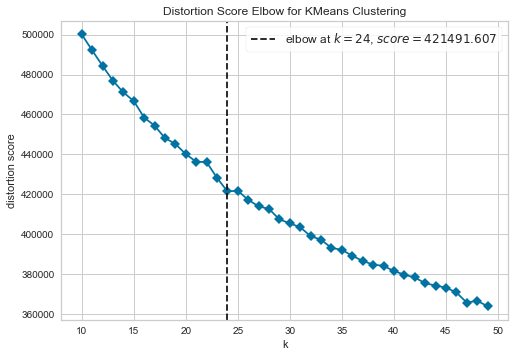

optimal number of k = 24, number_features = 48
--- run time : 5.716219711303711 min ---
subseting for M2, the shape is :  (15105, 479)
subseting for group = M2 with known ecoclassname, the shape is :  (5763, 479)


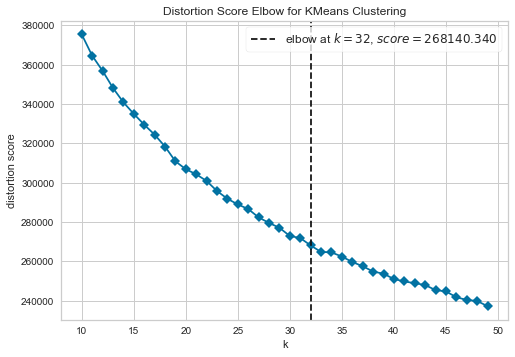

optimal number of k = 32, number_features = 40
--- run time : 5.600435324509939 min ---
subseting for D2, the shape is :  (15076, 479)
subseting for group = D2 with known ecoclassname, the shape is :  (10042, 479)


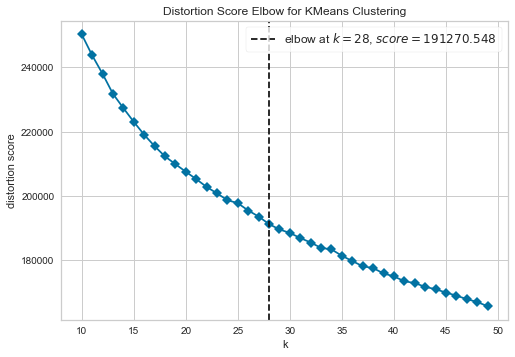

optimal number of k = 28, number_features = 30
--- run time : 5.6572849949200945 min ---
subseting for K4, the shape is :  (11808, 479)
subseting for group = K4 with known ecoclassname, the shape is :  (1171, 479)


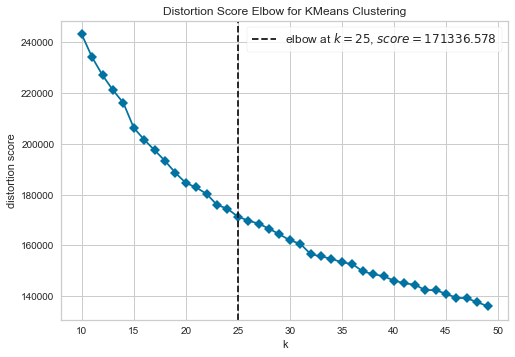

optimal number of k = 25, number_features = 38
--- run time : 2.85199290116628 min ---
subseting for E2, the shape is :  (10575, 479)
subseting for group = E2 with known ecoclassname, the shape is :  (1639, 479)


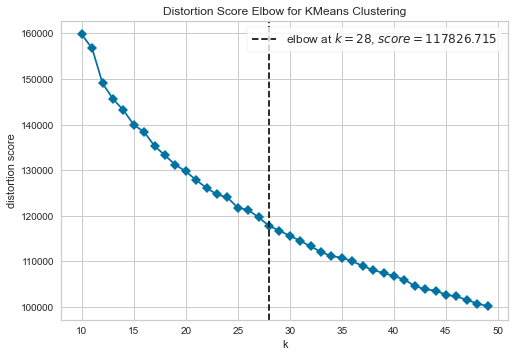

optimal number of k = 28, number_features = 29
--- run time : 3.1638143181800844 min ---
subseting for X2, the shape is :  (10182, 479)
subseting for group = X2 with known ecoclassname, the shape is :  (1038, 479)


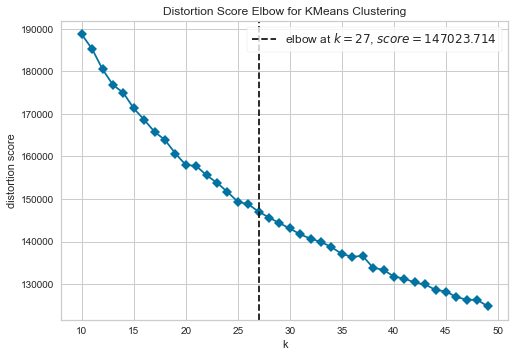

optimal number of k = 27, number_features = 30
--- run time : 2.91250657637914 min ---
subseting for E3, the shape is :  (9616, 479)
subseting for group = E3 with known ecoclassname, the shape is :  (1129, 479)


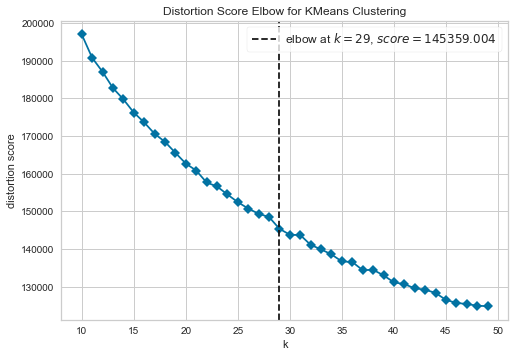

optimal number of k = 29, number_features = 35
--- run time : 2.0766711870829266 min ---
subseting for H2, the shape is :  (9461, 479)
subseting for group = H2 with known ecoclassname, the shape is :  (6145, 479)


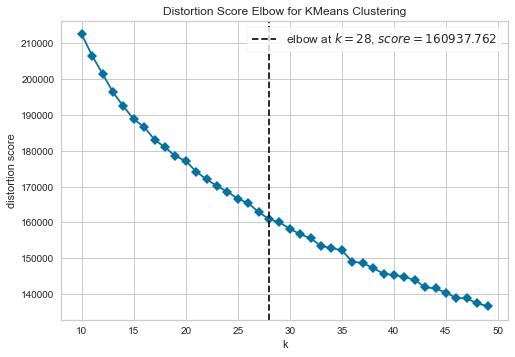

optimal number of k = 28, number_features = 38
--- run time : 2.418475341796875 min ---
subseting for D7, the shape is :  (9373, 479)
subseting for group = D7 with known ecoclassname, the shape is :  (3341, 479)


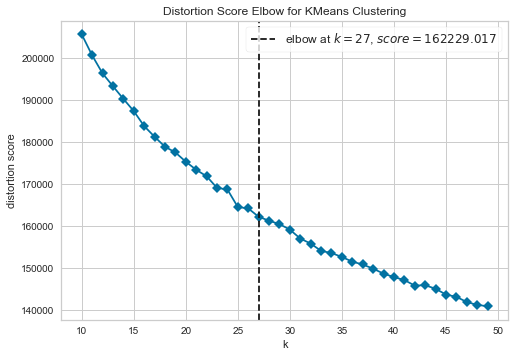

optimal number of k = 27, number_features = 35
--- run time : 2.728408360481262 min ---
subseting for W1, the shape is :  (9342, 479)
subseting for group = W1 with known ecoclassname, the shape is :  (481, 479)


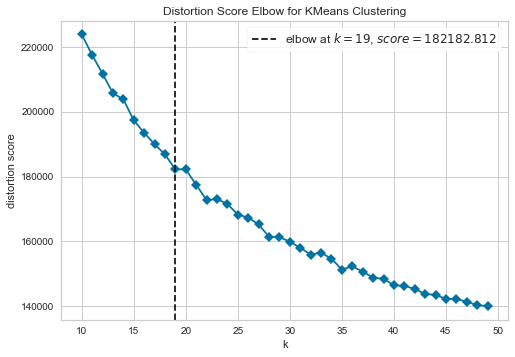

optimal number of k = 19, number_features = 36
--- run time : 1.6918776432673137 min ---
subseting for M7, the shape is :  (9325, 479)
subseting for group = M7 with known ecoclassname, the shape is :  (6805, 479)


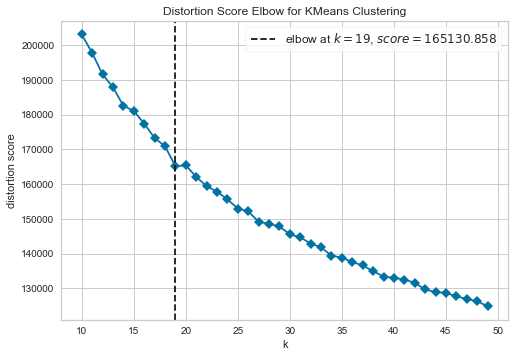

optimal number of k = 19, number_features = 42
--- run time : 1.8090428749720255 min ---
subseting for T1, the shape is :  (9187, 479)
subseting for group = T1 with known ecoclassname, the shape is :  (6361, 479)


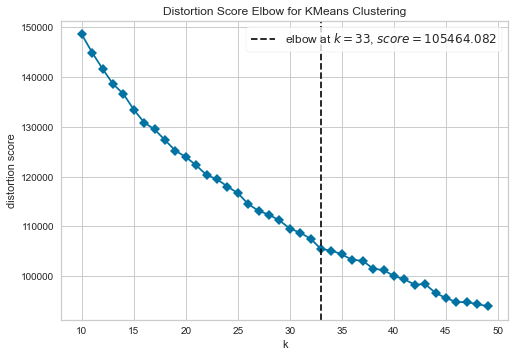

optimal number of k = 33, number_features = 32
--- run time : 2.3874950687090557 min ---
subseting for M1, the shape is :  (8909, 479)
subseting for group = M1 with known ecoclassname, the shape is :  (4778, 479)


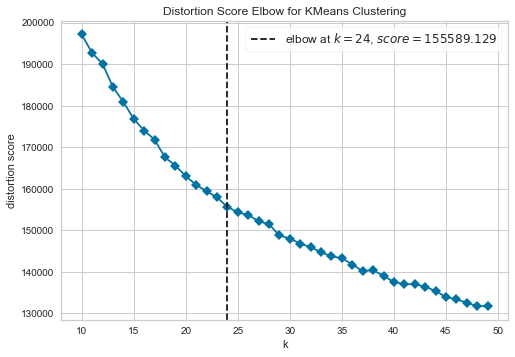

optimal number of k = 24, number_features = 39
--- run time : 2.2966683785120647 min ---
subseting for R3, the shape is :  (8330, 479)
subseting for group = R3 with known ecoclassname, the shape is :  (2457, 479)


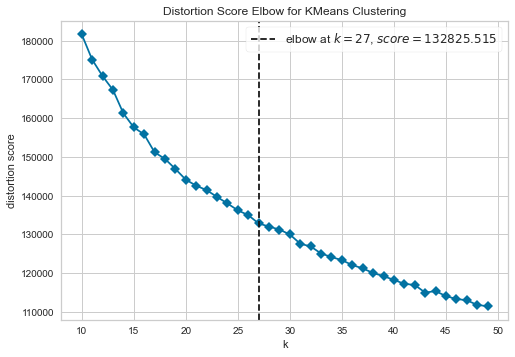

optimal number of k = 27, number_features = 34
--- run time : 2.2732839663823445 min ---
subseting for O1, the shape is :  (8142, 479)
subseting for group = O1 with known ecoclassname, the shape is :  (1836, 479)


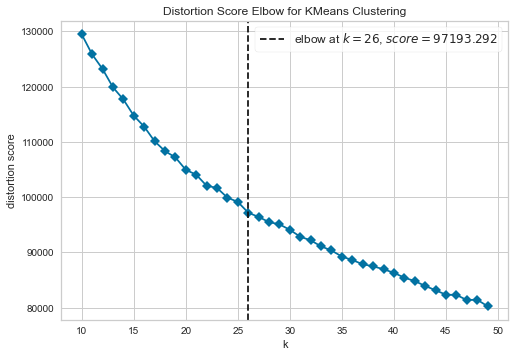

optimal number of k = 26, number_features = 33
--- run time : 1.6807843009630838 min ---
subseting for I3, the shape is :  (8140, 479)
subseting for group = I3 with known ecoclassname, the shape is :  (4529, 479)


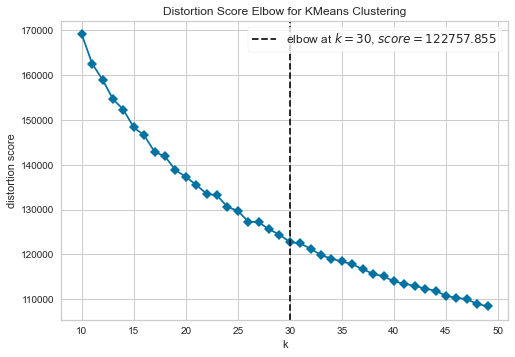

optimal number of k = 30, number_features = 35
--- run time : 2.7398236870765684 min ---
subseting for N6, the shape is :  (8114, 479)
subseting for group = N6 with known ecoclassname, the shape is :  (672, 479)


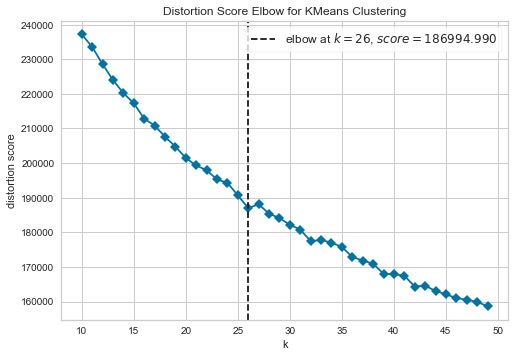

optimal number of k = 26, number_features = 46
--- run time : 2.022223762671153 min ---
subseting for D3, the shape is :  (8105, 479)
subseting for group = D3 with known ecoclassname, the shape is :  (4490, 479)


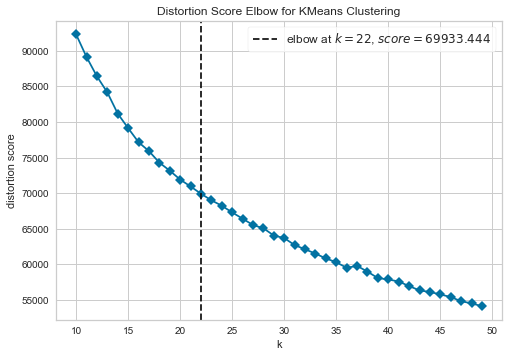

optimal number of k = 22, number_features = 24
--- run time : 2.5874776323636373 min ---
subseting for D4, the shape is :  (8012, 479)
subseting for group = D4 with known ecoclassname, the shape is :  (3153, 479)


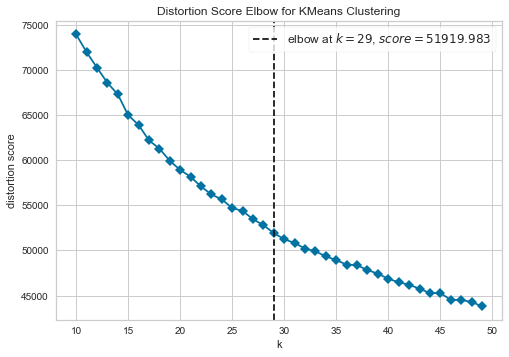

optimal number of k = 29, number_features = 21
--- run time : 2.5620907028516133 min ---
subseting for H4, the shape is :  (7721, 479)
subseting for group = H4 with known ecoclassname, the shape is :  (4051, 479)


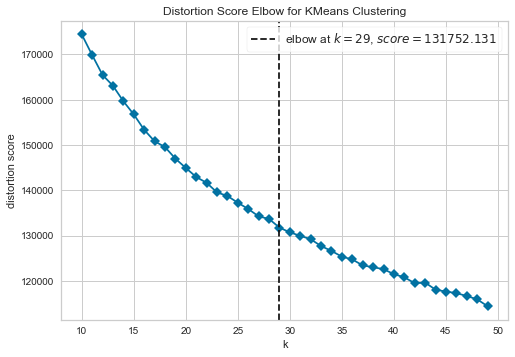

optimal number of k = 29, number_features = 38
--- run time : 2.2320584336916607 min ---
subseting for X1, the shape is :  (7615, 479)
subseting for group = X1 with known ecoclassname, the shape is :  (1582, 479)


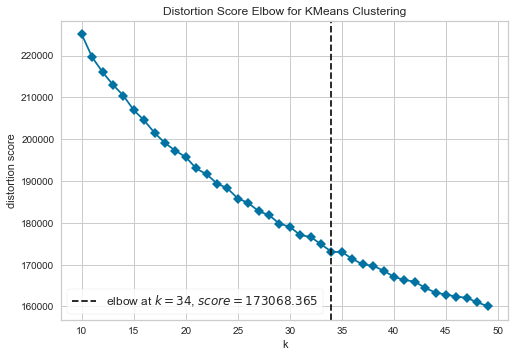

optimal number of k = 34, number_features = 46
--- run time : 2.787076958020528 min ---
subseting for H1, the shape is :  (7547, 479)
subseting for group = H1 with known ecoclassname, the shape is :  (5098, 479)


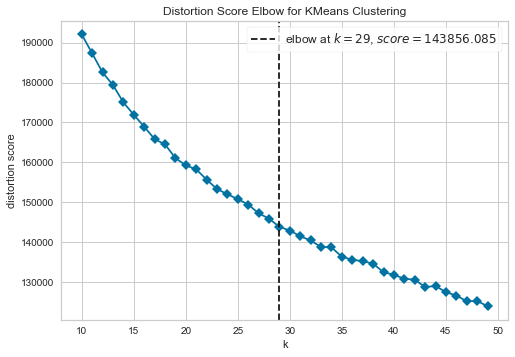

optimal number of k = 29, number_features = 46
--- run time : 2.1881380995114643 min ---
subseting for M5, the shape is :  (7518, 479)
subseting for group = M5 with known ecoclassname, the shape is :  (3782, 479)


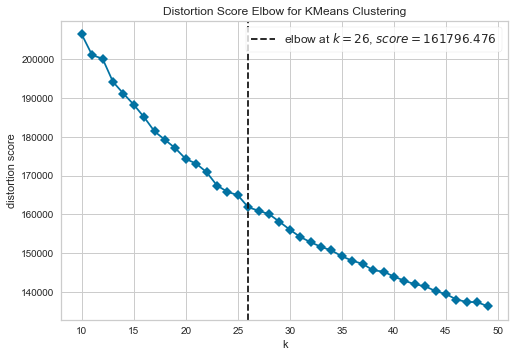

optimal number of k = 26, number_features = 43
--- run time : 2.1356979807217917 min ---
subseting for D6, the shape is :  (7286, 479)
subseting for group = D6 with known ecoclassname, the shape is :  (2534, 479)


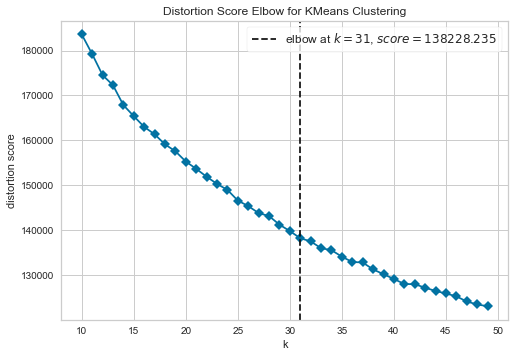

optimal number of k = 31, number_features = 41
--- run time : 2.443592854340871 min ---
subseting for H5, the shape is :  (7214, 479)
subseting for group = H5 with known ecoclassname, the shape is :  (5160, 479)


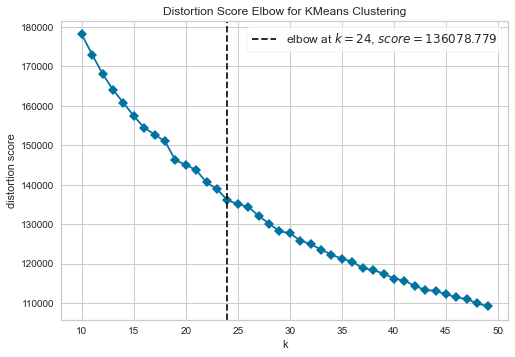

optimal number of k = 24, number_features = 44
--- run time : 1.6394342343012491 min ---
subseting for N5, the shape is :  (6500, 479)
subseting for group = N5 with known ecoclassname, the shape is :  (184, 479)


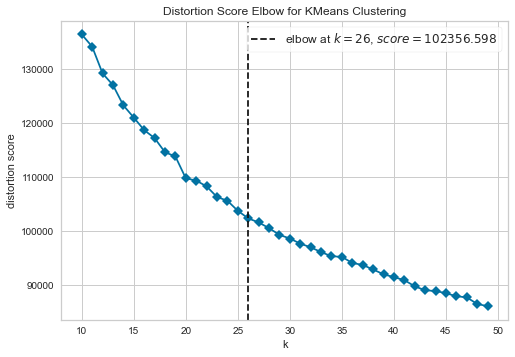

optimal number of k = 26, number_features = 35
--- run time : 1.5768388787905374 min ---
subseting for K3, the shape is :  (6178, 479)
subseting for group = K3 with known ecoclassname, the shape is :  (2375, 479)


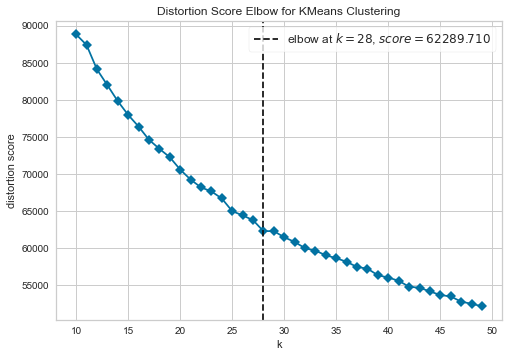

optimal number of k = 28, number_features = 27
--- run time : 1.3761285463968913 min ---
subseting for M10, the shape is :  (5955, 479)
subseting for group = M10 with known ecoclassname, the shape is :  (2108, 479)


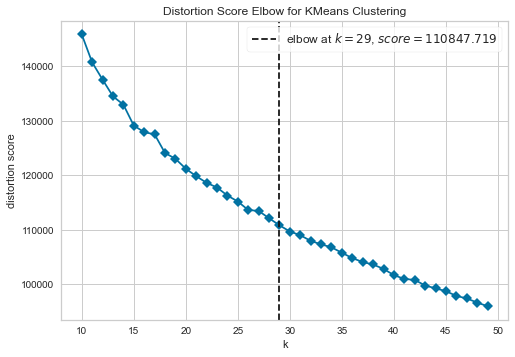

optimal number of k = 29, number_features = 41
--- run time : 1.7812268614768982 min ---
subseting for G4, the shape is :  (5709, 479)
subseting for group = G4 with known ecoclassname, the shape is :  (2126, 479)


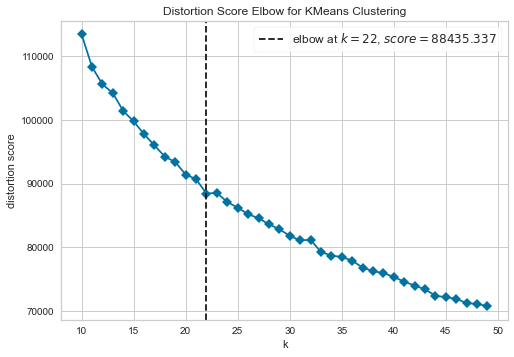

optimal number of k = 22, number_features = 34
--- run time : 1.4091341098149617 min ---
subseting for D1, the shape is :  (5025, 479)
subseting for group = D1 with known ecoclassname, the shape is :  (2269, 479)


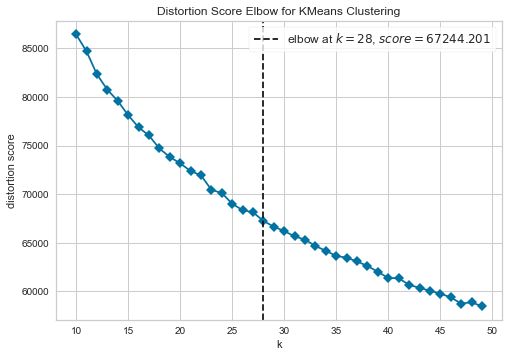

optimal number of k = 28, number_features = 32
--- run time : 1.521612811088562 min ---
subseting for N4, the shape is :  (4944, 479)
subseting for group = N4 with known ecoclassname, the shape is :  (49, 479)


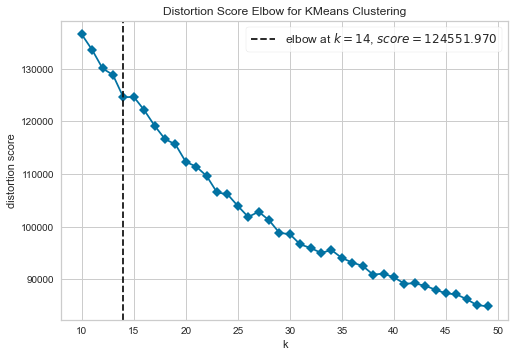

optimal number of k = 14, number_features = 40
--- run time : 0.7860427538553874 min ---
subseting for S2, the shape is :  (4927, 479)


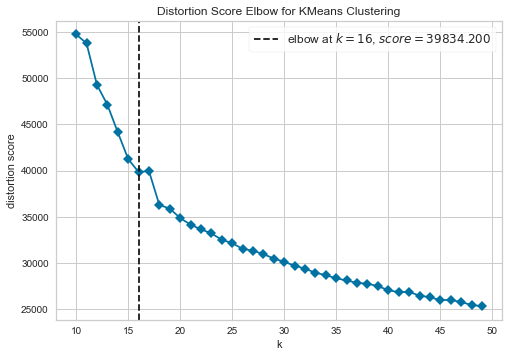

optimal number of k = 16, number_features = 20
--- run time : 0.8538320223490398 min ---
subseting for G1, the shape is :  (4859, 479)
subseting for group = G1 with known ecoclassname, the shape is :  (2256, 479)


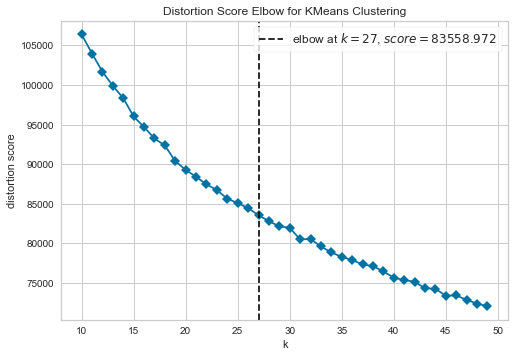

optimal number of k = 27, number_features = 35
--- run time : 1.3657899936040243 min ---
subseting for P3, the shape is :  (4810, 479)
subseting for group = P3 with known ecoclassname, the shape is :  (177, 479)


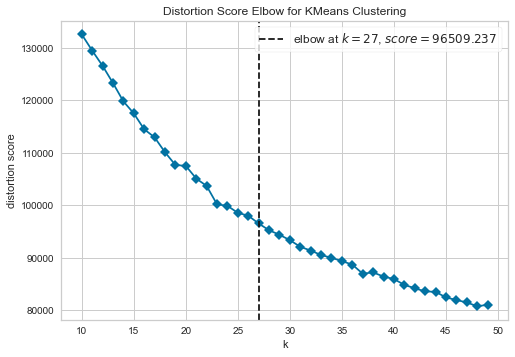

optimal number of k = 27, number_features = 41
--- run time : 1.4477595647176107 min ---
subseting for I1, the shape is :  (4514, 479)
subseting for group = I1 with known ecoclassname, the shape is :  (1998, 479)


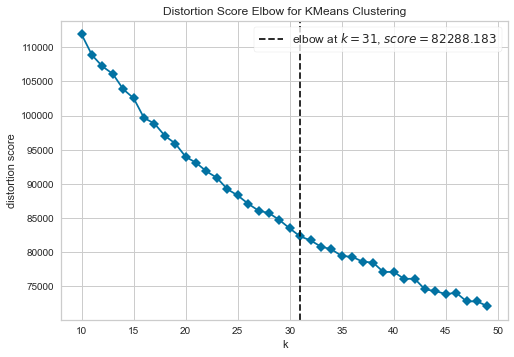

optimal number of k = 31, number_features = 44
--- run time : 1.150020428498586 min ---
subseting for L1, the shape is :  (4283, 479)
subseting for group = L1 with known ecoclassname, the shape is :  (1737, 479)


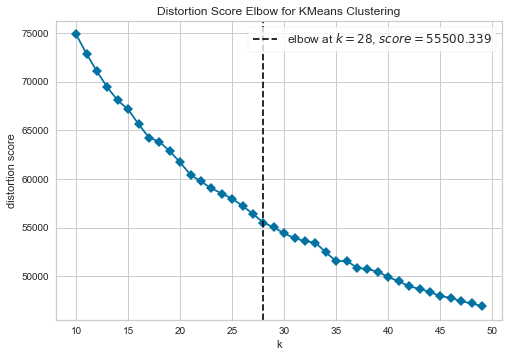

optimal number of k = 28, number_features = 36
--- run time : 0.9888943274815877 min ---
subseting for R2, the shape is :  (4179, 479)
subseting for group = R2 with known ecoclassname, the shape is :  (24, 479)


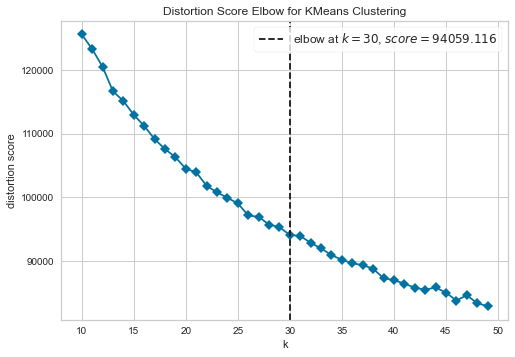

optimal number of k = 30, number_features = 44
--- run time : 1.2344059030214944 min ---
subseting for R1, the shape is :  (7443, 479)
subseting for group = R1 with known ecoclassname, the shape is :  (1783, 479)


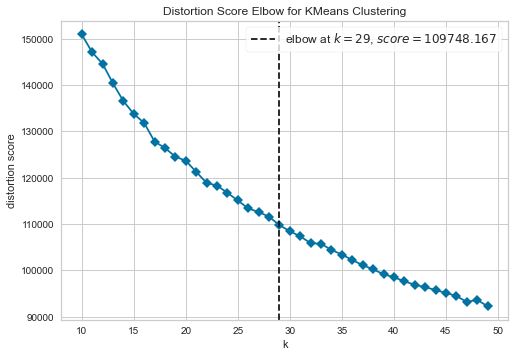

optimal number of k = 29, number_features = 34
--- run time : 1.7589871486028035 min ---
subseting for B2, the shape is :  (3935, 479)
subseting for group = B2 with known ecoclassname, the shape is :  (1305, 479)


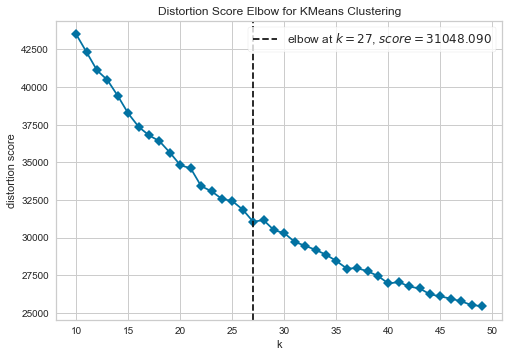

optimal number of k = 27, number_features = 20
--- run time : 1.0551605264345805 min ---
subseting for M8, the shape is :  (3784, 479)
subseting for group = M8 with known ecoclassname, the shape is :  (1534, 479)


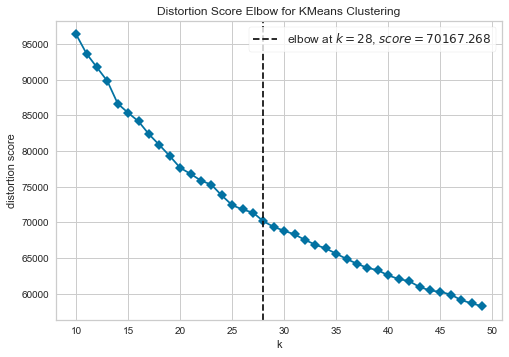

optimal number of k = 28, number_features = 42
--- run time : 0.828377636273702 min ---
subseting for M4, the shape is :  (3735, 479)
subseting for group = M4 with known ecoclassname, the shape is :  (1387, 479)


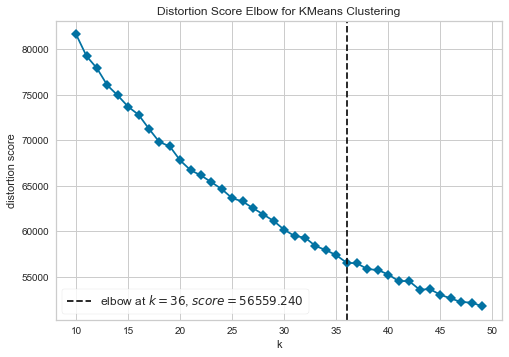

optimal number of k = 36, number_features = 37
--- run time : 0.9153742313385009 min ---
subseting for K2, the shape is :  (3664, 479)
subseting for group = K2 with known ecoclassname, the shape is :  (1761, 479)


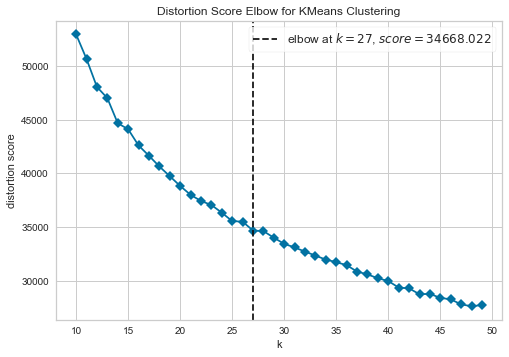

optimal number of k = 27, number_features = 28
--- run time : 0.7097006797790527 min ---
subseting for E4, the shape is :  (3600, 479)
subseting for group = E4 with known ecoclassname, the shape is :  (454, 479)


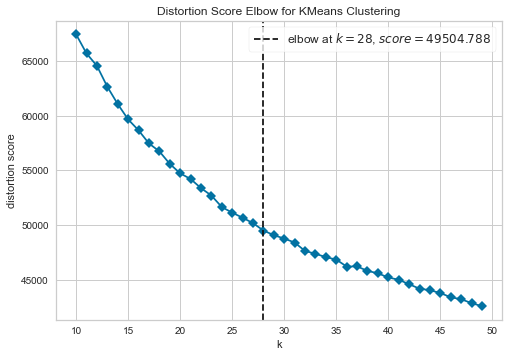

optimal number of k = 28, number_features = 33
--- run time : 0.809061066309611 min ---
subseting for J1, the shape is :  (3390, 479)
subseting for group = J1 with known ecoclassname, the shape is :  (2074, 479)


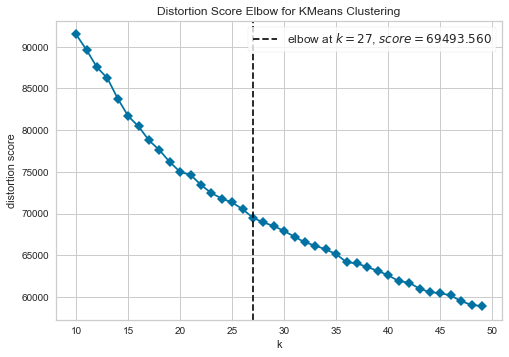

optimal number of k = 27, number_features = 46
--- run time : 0.8583086927731832 min ---
subseting for H6, the shape is :  (3347, 479)
subseting for group = H6 with known ecoclassname, the shape is :  (2490, 479)


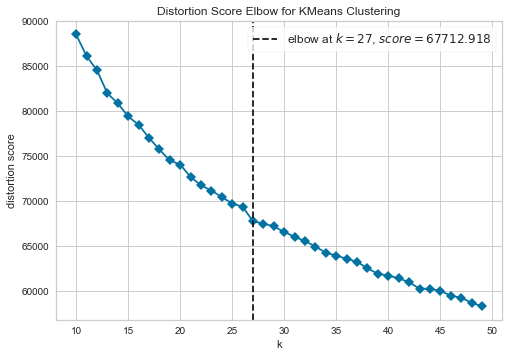

optimal number of k = 27, number_features = 44
--- run time : 0.9053186297416687 min ---
subseting for F3, the shape is :  (3262, 479)
subseting for group = F3 with known ecoclassname, the shape is :  (2171, 479)


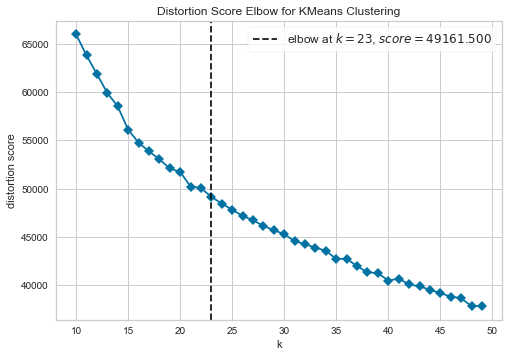

optimal number of k = 23, number_features = 35
--- run time : 0.6868702530860901 min ---
subseting for M6, the shape is :  (3031, 479)
subseting for group = M6 with known ecoclassname, the shape is :  (1566, 479)


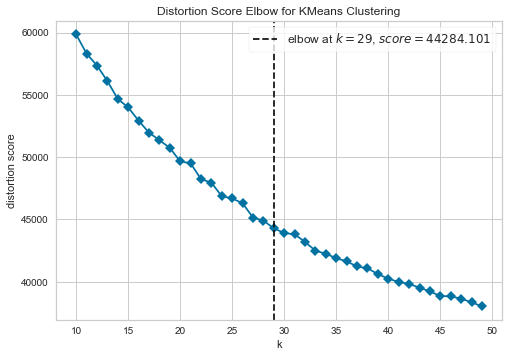

optimal number of k = 29, number_features = 35
--- run time : 0.6945975065231323 min ---
subseting for J3, the shape is :  (3005, 479)
subseting for group = J3 with known ecoclassname, the shape is :  (1570, 479)


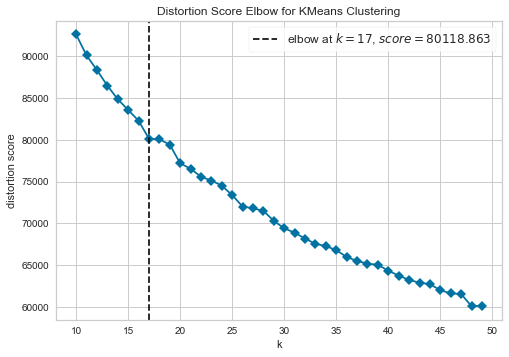

optimal number of k = 17, number_features = 47
--- run time : 0.6376833995183309 min ---
subseting for K1, the shape is :  (2987, 479)
subseting for group = K1 with known ecoclassname, the shape is :  (1247, 479)


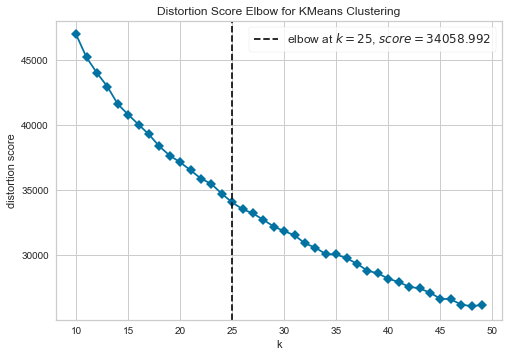

optimal number of k = 25, number_features = 29
--- run time : 0.5783845782279968 min ---
subseting for I2, the shape is :  (2867, 479)
subseting for group = I2 with known ecoclassname, the shape is :  (1726, 479)


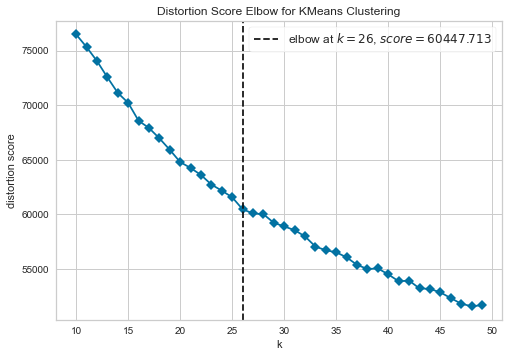

optimal number of k = 26, number_features = 42
--- run time : 0.6925552487373352 min ---
subseting for T3, the shape is :  (2858, 479)
subseting for group = T3 with known ecoclassname, the shape is :  (163, 479)


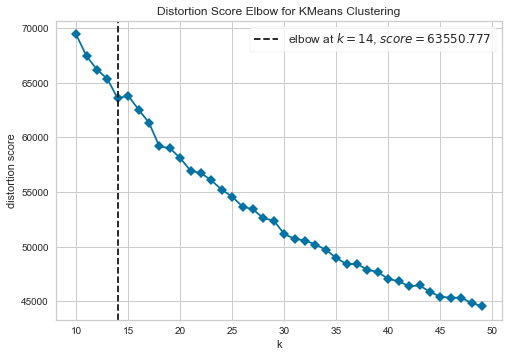

optimal number of k = 14, number_features = 39
--- run time : 0.4843080401420593 min ---
subseting for F1, the shape is :  (2831, 479)
subseting for group = F1 with known ecoclassname, the shape is :  (1563, 479)


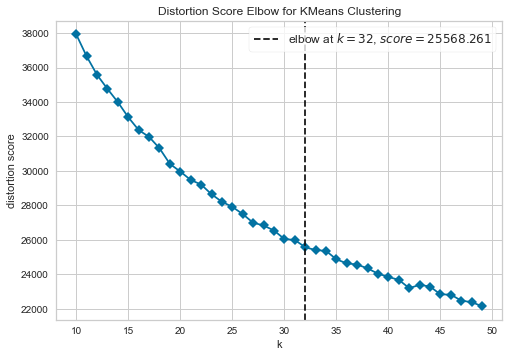

optimal number of k = 32, number_features = 27
--- run time : 0.6818603277206421 min ---
subseting for T2, the shape is :  (2726, 479)
subseting for group = T2 with known ecoclassname, the shape is :  (2072, 479)


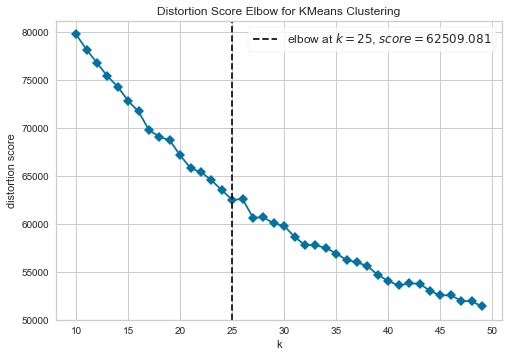

optimal number of k = 25, number_features = 44
--- run time : 0.6803975780804952 min ---
subseting for L2, the shape is :  (2668, 479)
subseting for group = L2 with known ecoclassname, the shape is :  (1405, 479)


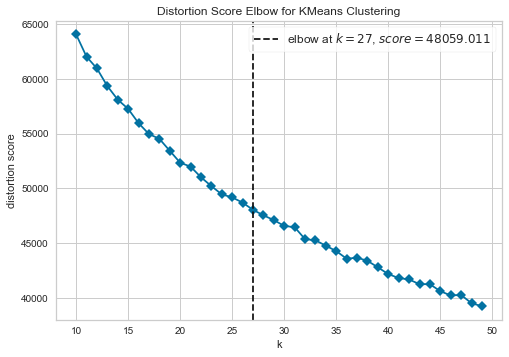

optimal number of k = 27, number_features = 44
--- run time : 0.598507829507192 min ---
subseting for A2, the shape is :  (2634, 479)
subseting for group = A2 with known ecoclassname, the shape is :  (575, 479)


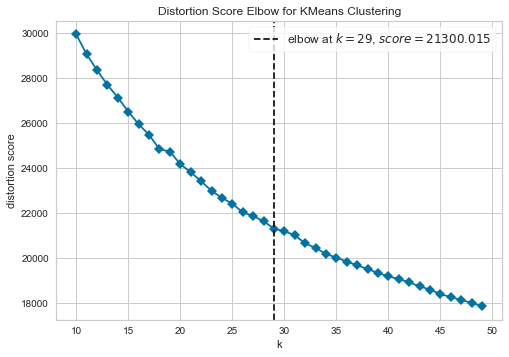

optimal number of k = 29, number_features = 25
--- run time : 0.6204088687896728 min ---
subseting for S1, the shape is :  (2531, 479)


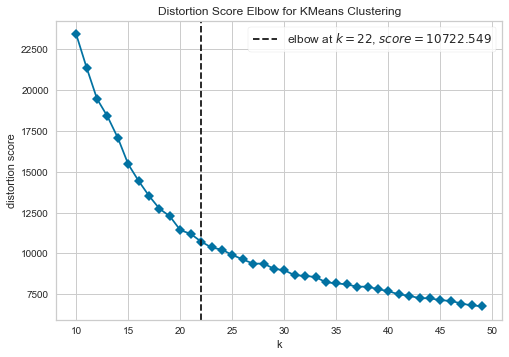

optimal number of k = 22, number_features = 20
--- run time : 0.3853703657786051 min ---
subseting for J4, the shape is :  (2604, 479)
subseting for group = J4 with known ecoclassname, the shape is :  (1043, 479)


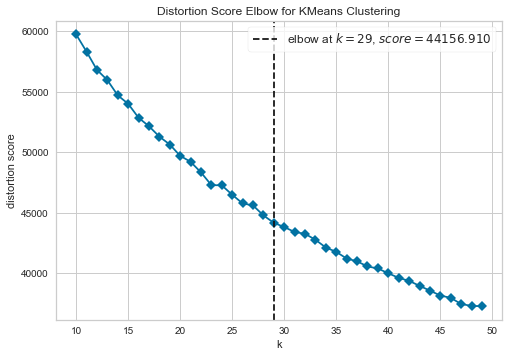

optimal number of k = 29, number_features = 40
--- run time : 0.5914954304695129 min ---
subseting for A1, the shape is :  (2176, 479)
subseting for group = A1 with known ecoclassname, the shape is :  (437, 479)


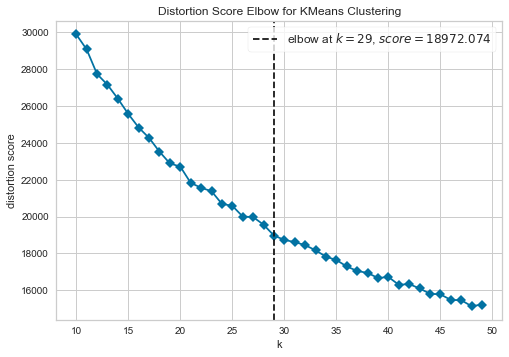

optimal number of k = 29, number_features = 30
--- run time : 0.4421617348988851 min ---
subseting for N3, the shape is :  (2295, 479)
subseting for group = N3 with known ecoclassname, the shape is :  (159, 479)


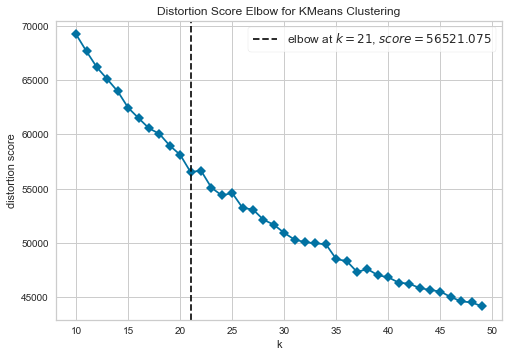

optimal number of k = 21, number_features = 47
--- run time : 0.48584357897440594 min ---
subseting for J2, the shape is :  (2258, 479)
subseting for group = J2 with known ecoclassname, the shape is :  (706, 479)


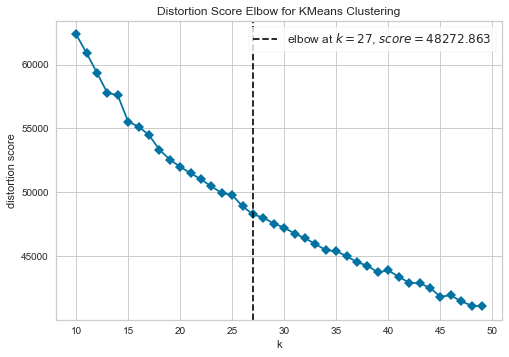

optimal number of k = 27, number_features = 45
--- run time : 0.5741812547047933 min ---
subseting for K5, the shape is :  (2234, 479)
subseting for group = K5 with known ecoclassname, the shape is :  (944, 479)


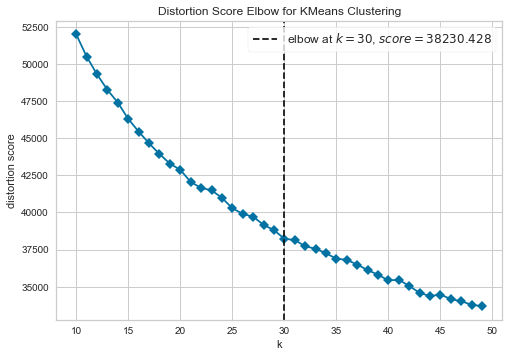

optimal number of k = 30, number_features = 38
--- run time : 0.513158130645752 min ---
subseting for P2, the shape is :  (2152, 479)
subseting for group = P2 with known ecoclassname, the shape is :  (157, 479)


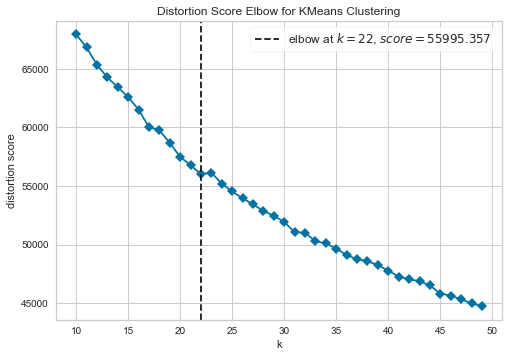

optimal number of k = 22, number_features = 46
--- run time : 0.45470481316248573 min ---
subseting for K6, the shape is :  (2136, 479)
subseting for group = K6 with known ecoclassname, the shape is :  (806, 479)


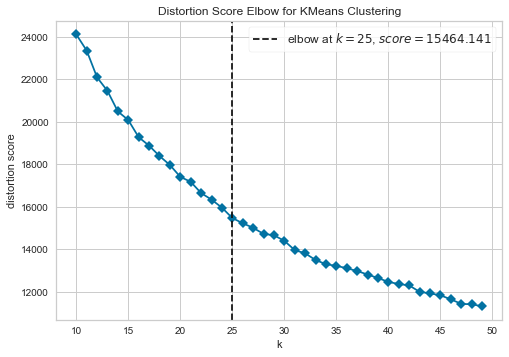

optimal number of k = 25, number_features = 24
--- run time : 0.4075519839922587 min ---
subseting for G2, the shape is :  (2052, 479)
subseting for group = G2 with known ecoclassname, the shape is :  (1224, 479)


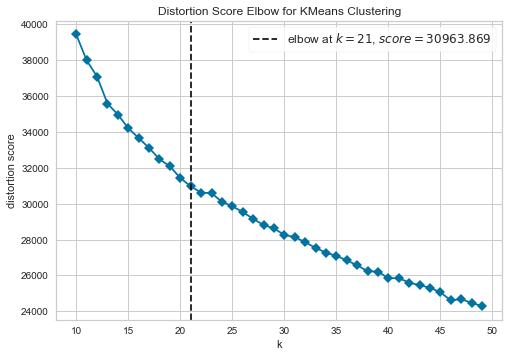

optimal number of k = 21, number_features = 35
--- run time : 0.4524274269739787 min ---
subseting for G5, the shape is :  (2017, 479)
subseting for group = G5 with known ecoclassname, the shape is :  (1426, 479)


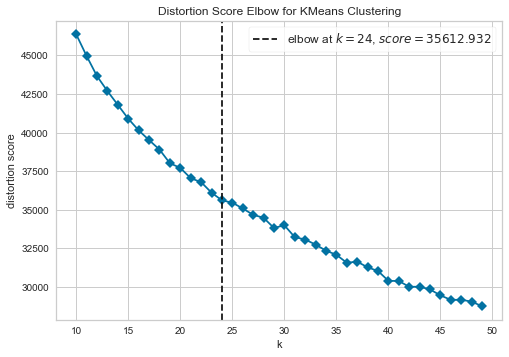

optimal number of k = 24, number_features = 40
--- run time : 0.4980927030245463 min ---
subseting for F4, the shape is :  (1986, 479)
subseting for group = F4 with known ecoclassname, the shape is :  (836, 479)


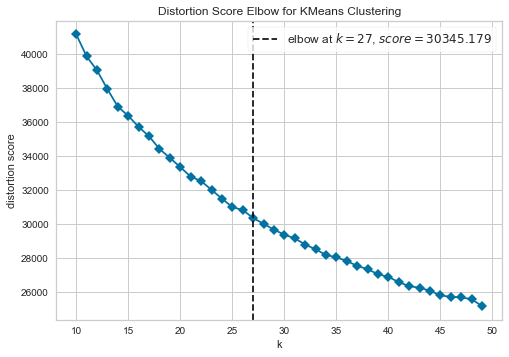

optimal number of k = 27, number_features = 34
--- run time : 0.4574851592381795 min ---
subseting for A3, the shape is :  (1926, 479)
subseting for group = A3 with known ecoclassname, the shape is :  (347, 479)


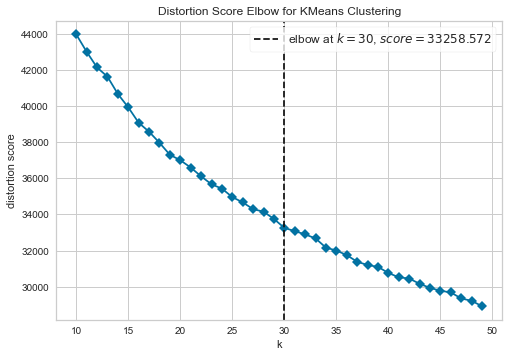

optimal number of k = 30, number_features = 39
--- run time : 0.4645782828330994 min ---
subseting for D8, the shape is :  (1928, 479)
subseting for group = D8 with known ecoclassname, the shape is :  (1057, 479)


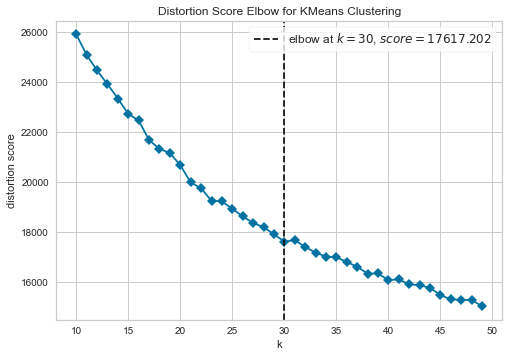

optimal number of k = 30, number_features = 27
--- run time : 0.5183365980784098 min ---
subseting for C3, the shape is :  (1926, 479)
subseting for group = C3 with known ecoclassname, the shape is :  (1148, 479)


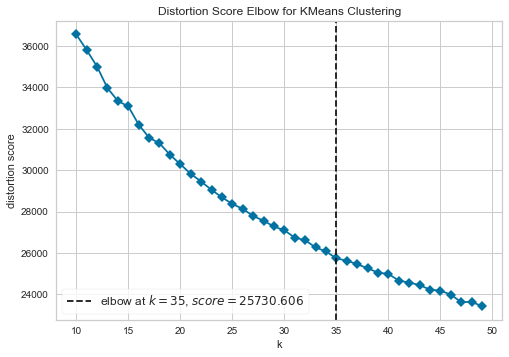

optimal number of k = 35, number_features = 34
--- run time : 0.5857446114222209 min ---
subseting for G6, the shape is :  (1795, 479)
subseting for group = G6 with known ecoclassname, the shape is :  (1051, 479)


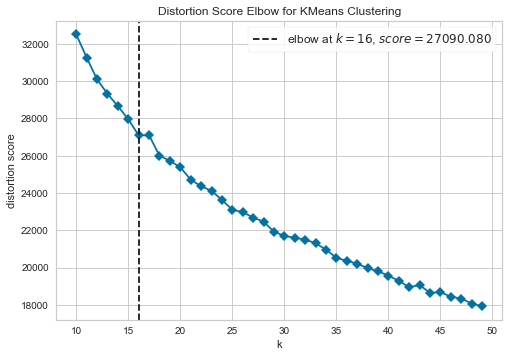

optimal number of k = 16, number_features = 37
--- run time : 0.4113449494043986 min ---
subseting for N7, the shape is :  (1522, 479)


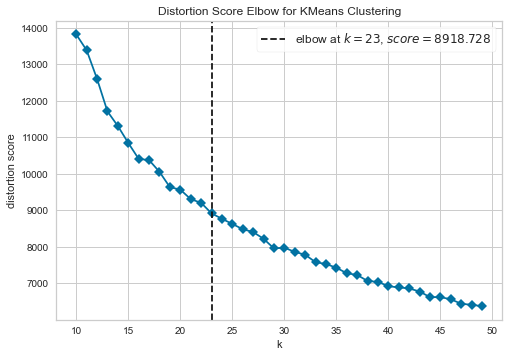

optimal number of k = 23, number_features = 20
--- run time : 0.3108792503674825 min ---
subseting for B3, the shape is :  (1524, 479)
subseting for group = B3 with known ecoclassname, the shape is :  (569, 479)


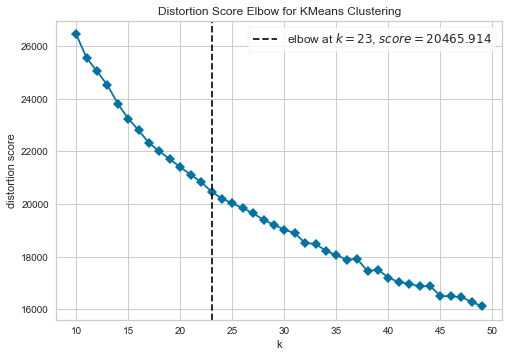

optimal number of k = 23, number_features = 34
--- run time : 0.3280376672744751 min ---
subseting for G3, the shape is :  (1505, 479)
subseting for group = G3 with known ecoclassname, the shape is :  (823, 479)


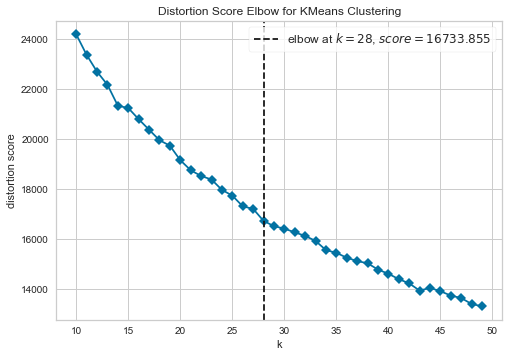

optimal number of k = 28, number_features = 31
--- run time : 0.3448442022005717 min ---
subseting for N2, the shape is :  (1499, 479)
subseting for group = N2 with known ecoclassname, the shape is :  (421, 479)


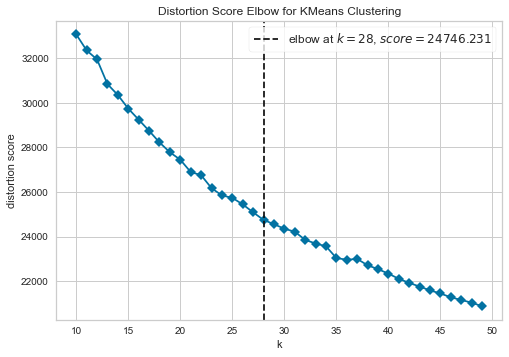

optimal number of k = 28, number_features = 35
--- run time : 0.40656190713246665 min ---
subseting for C1, the shape is :  (1458, 479)
subseting for group = C1 with known ecoclassname, the shape is :  (442, 479)


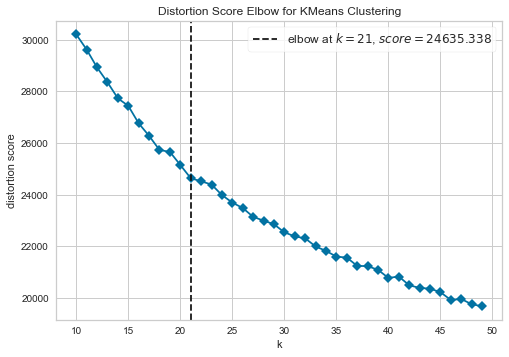

optimal number of k = 21, number_features = 34
--- run time : 0.3647641698519389 min ---
subseting for M9, the shape is :  (1353, 479)
subseting for group = M9 with known ecoclassname, the shape is :  (193, 479)


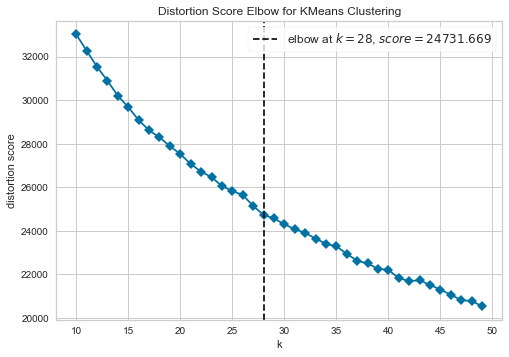

optimal number of k = 28, number_features = 43
--- run time : 0.3140951196352641 min ---
subseting for B4, the shape is :  (1317, 479)
subseting for group = B4 with known ecoclassname, the shape is :  (250, 479)


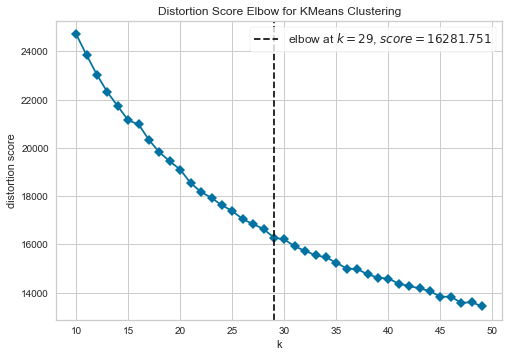

optimal number of k = 29, number_features = 31
--- run time : 0.3257679979006449 min ---
subseting for C2, the shape is :  (1279, 479)
subseting for group = C2 with known ecoclassname, the shape is :  (170, 479)


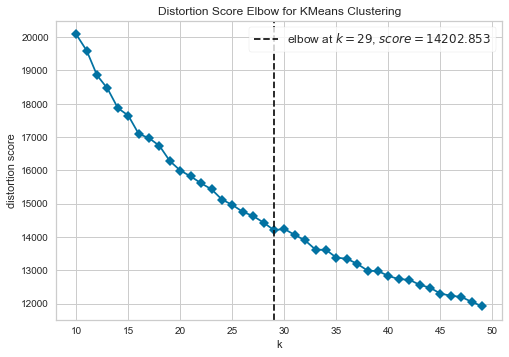

optimal number of k = 29, number_features = 27
--- run time : 0.2979726036389669 min ---
subseting for B5, the shape is :  (1261, 479)
subseting for group = B5 with known ecoclassname, the shape is :  (616, 479)


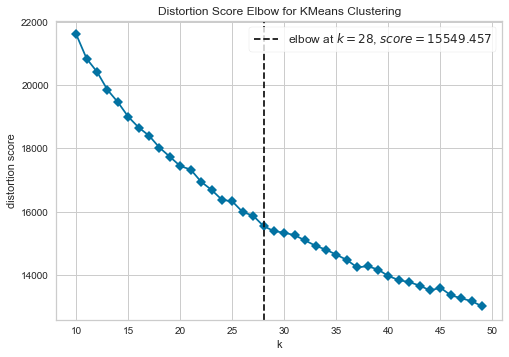

optimal number of k = 28, number_features = 35
--- run time : 0.2969627380371094 min ---
subseting for W2, the shape is :  (1257, 479)


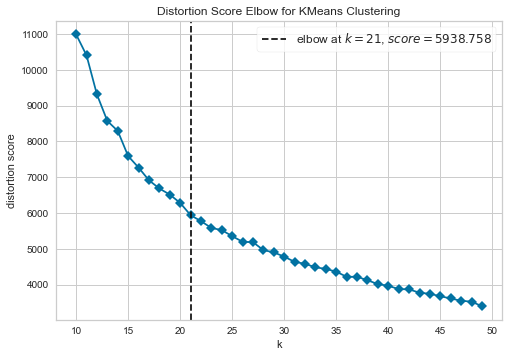

optimal number of k = 21, number_features = 20
--- run time : 0.22229411204655966 min ---
subseting for D5, the shape is :  (1237, 479)
subseting for group = D5 with known ecoclassname, the shape is :  (937, 479)


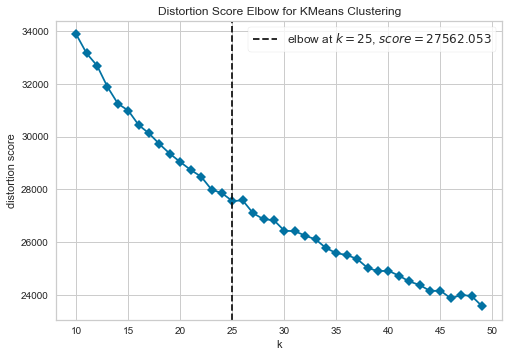

optimal number of k = 25, number_features = 42
--- run time : 0.33871419429779054 min ---
subseting for A4, the shape is :  (1218, 479)
subseting for group = A4 with known ecoclassname, the shape is :  (90, 479)


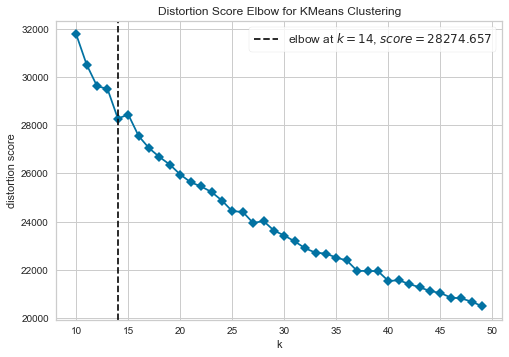

optimal number of k = 14, number_features = 43
--- run time : 0.2760370373725891 min ---
subseting for C4, the shape is :  (1187, 479)


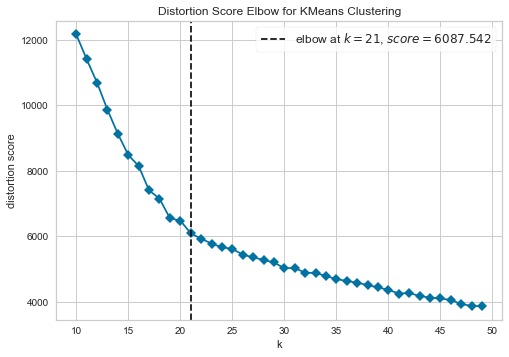

optimal number of k = 21, number_features = 20
--- run time : 0.19844162066777546 min ---
subseting for B1, the shape is :  (1181, 479)
subseting for group = B1 with known ecoclassname, the shape is :  (423, 479)


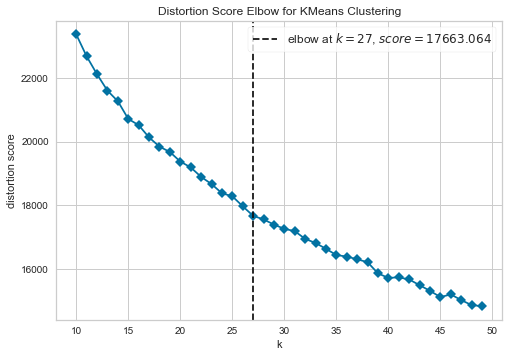

optimal number of k = 27, number_features = 35
--- run time : 0.2940556645393372 min ---
subseting for C5, the shape is :  (1149, 479)
subseting for group = C5 with known ecoclassname, the shape is :  (149, 479)


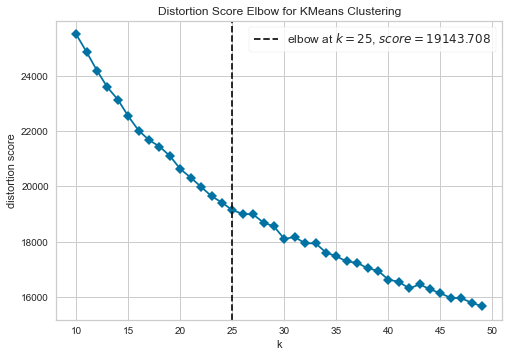

optimal number of k = 25, number_features = 36
--- run time : 0.2724165121714274 min ---
subseting for U2, the shape is :  (1039, 479)
subseting for group = U2 with known ecoclassname, the shape is :  (661, 479)


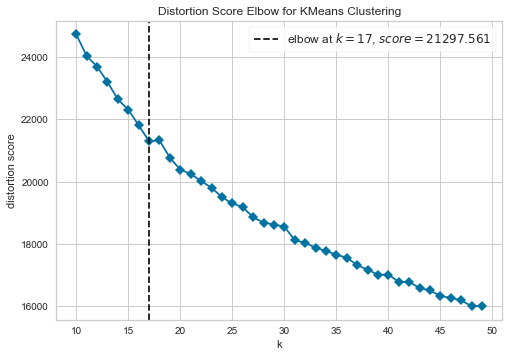

optimal number of k = 17, number_features = 37
--- run time : 0.2730461597442627 min ---
subseting for F2, the shape is :  (948, 479)
subseting for group = F2 with known ecoclassname, the shape is :  (510, 479)


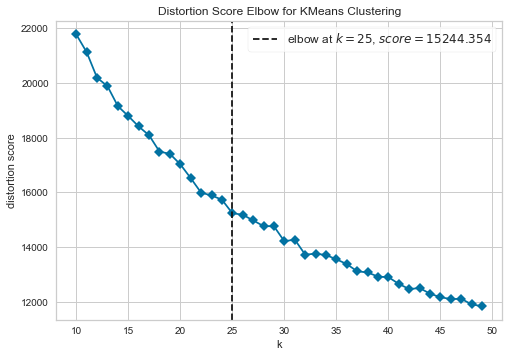

optimal number of k = 25, number_features = 35
--- run time : 0.2384239713350932 min ---
subseting for E5, the shape is :  (923, 479)
subseting for group = E5 with known ecoclassname, the shape is :  (503, 479)


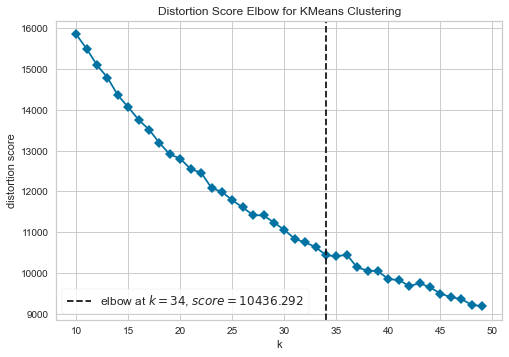

optimal number of k = 34, number_features = 34
--- run time : 0.23606654405593872 min ---
subseting for S3, the shape is :  (875, 479)
subseting for group = S3 with known ecoclassname, the shape is :  (111, 479)


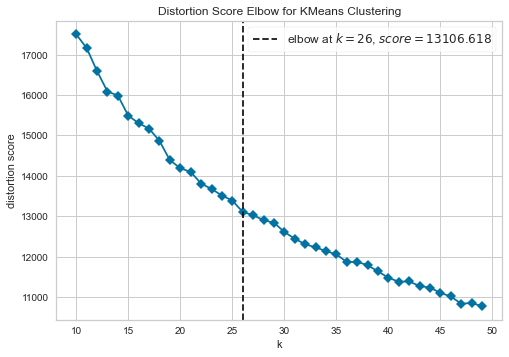

optimal number of k = 26, number_features = 33
--- run time : 0.2208324948946635 min ---
subseting for U1, the shape is :  (866, 479)
subseting for group = U1 with known ecoclassname, the shape is :  (569, 479)


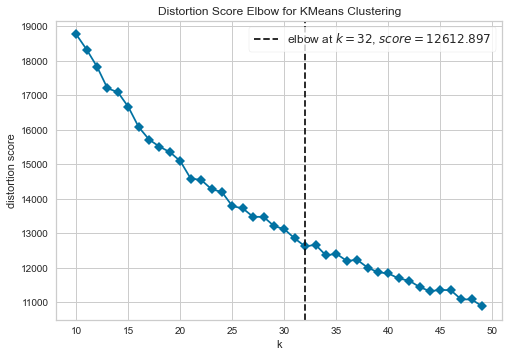

optimal number of k = 32, number_features = 35
--- run time : 0.23465356429417927 min ---
subseting for U3, the shape is :  (795, 479)
subseting for group = U3 with known ecoclassname, the shape is :  (190, 479)


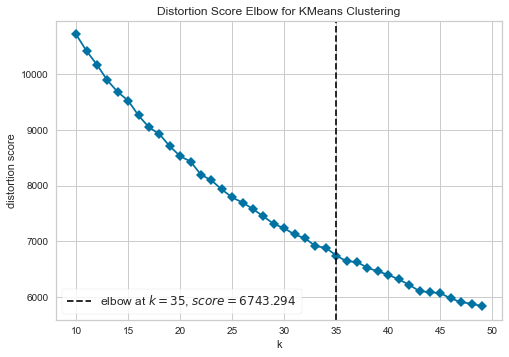

optimal number of k = 35, number_features = 29
--- run time : 0.22677009105682372 min ---
subseting for Q1, the shape is :  (761, 479)


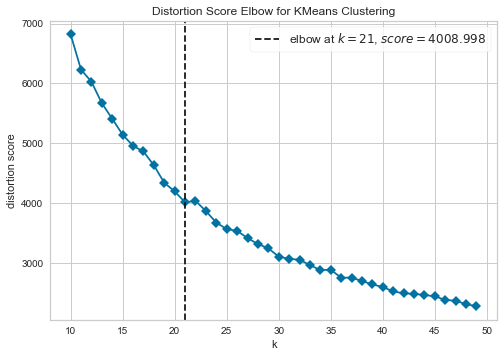

optimal number of k = 21, number_features = 20
--- run time : 0.15757686297098797 min ---
subseting for V1, the shape is :  (712, 479)
subseting for group = V1 with known ecoclassname, the shape is :  (5, 479)


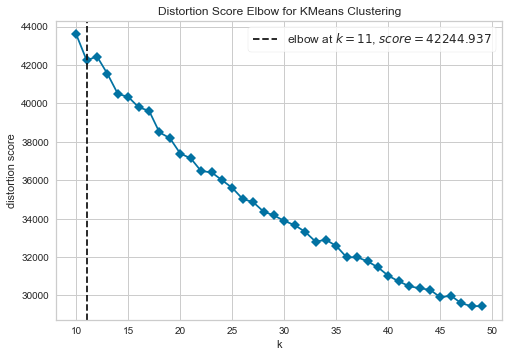

optimal number of k = 11, number_features = 74
--- run time : 0.2112339496612549 min ---
subseting for Z1, the shape is :  (536, 479)


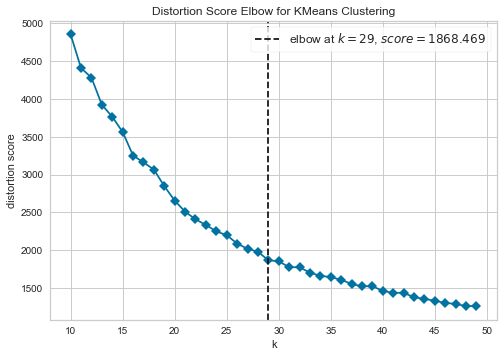

optimal number of k = 29, number_features = 20
--- run time : 0.1299137075742086 min ---


<Figure size 576x396 with 0 Axes>

In [7]:
# Loop
for group_name in Groups:
    start_time = time.time()
    group_ob = mlra_groups(model_data,group_name)
    group_ob.group_specific_feature_select_func()
    group_ob.find_optimum_k()
    group_ob.best_model_kmeans()
    group_ob.write_to_excel()
    del group_ob
    print("--- run time : {} min ---".format((time.time() - start_time)/60))
    


## Combine cluster data with modeling dataset
cluster data consists of clusters, top 5 features, and top 3 ecoclassnames. we add this information to the modeling dataset

In [8]:
import os
import glob
# we need to gather all the save_data_topeco_topfeature data files

os.chdir("Cluster_Group_Datasets/") # insert file directory where Output Files is kept

extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv("cluster_group_model_data.csv", index=False, encoding='utf-8-sig')